In [1]:
import pandas as pd
import numpy as np
import re
from fa2 import ForceAtlas2
import urllib.request
import json
import networkx as nx
import matplotlib.pyplot as plt
import math
import collections
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import requests
from geopy.geocoders import Nominatim
from pyvis.network import Network
from itertools import count
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import PlaintextCorpusReader
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sympy import symbols, solve
import community
import math
import community.community_louvain as community
import random
from random import randint
import heapq
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
import urllib.request
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, Label, LabelSet, Range1d
from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, GeoJSONDataSource, \
                        LinearColorMapper, ColorBar, NumeralTickFormatter, Div, Select, TableColumn, \
                        DataTable, CheckboxGroup, Tabs, Panel, CheckboxButtonGroup, RadioButtonGroup
from bokeh.io import show, output_notebook, curdoc, output_file
from bokeh.embed import file_html
import plotly.io as pio

# The Explainer Notebook

**Structure of this notebook**

The notebook consists of five parts; ["Motivation"](#part1), ["Data preparation Stats"](#part2), ["Basic Stats"](#part3), ["Tools, theory and analysis"](#part4), ["Discussion"](#part5) and ["Contributions"](#part6).

In the first part regarding motivation a description of the project goal is provided alongside an explanation of the dataset used. 

The Basic Stats aims to get an understanding of the dataset by using explorative statistics. This section provides an initial understanding of the data and an idea of what to investigate further. Furthermore, this section includes data extraction, cleaning and preparation for the network analysis.

The Tools, theory and analysis part contains two main parts; Network Analysis and Text Analysis. Each of these are divided into further sub-analyses. In the beginning of each sub-analysis a short presentation of theory and purpose is made. Throughout this section the tools will be explained when they are applied. At the end of each sub-analysis, the outcome is comment on.

The Discussion will both discuss main results, data quality and further work.

In the end of the explainer notebook the Contribution describes which part of the project each member has been responsible for. 

<a id='part1'></a>
## Part 1: Motivation

**Motivation and goal**

Music is an important part of the everyday life for most people. Whether it is music for a party, for the bus or the inescapable noice you hear in a telephone queue, it affects us in some way or another. But which words are we actually hearing when we put on our headphones? Are we exposing ourselves to positive or negative messages? Are we subconsciously choosing to listen to negative songs, postitive song or specific topics? And lastly how does the artists connect to one another, and what information can we derive from the different groupings?

These are the questions we seek to answer in this study. We want to investigate different artist and compare different genres to achive deeper insight in the music industri. Before starting the study we need to limit our project. There are quite frankly too many artists across the world for us to take them all into account with the limited computer power that we possess, so in order to make it manageble we chose to focus on five music genres.

Pop,      Hiphop,       RnB,      Rock and       Country

**Dataset**

The date for the study is based on the wikipedia lists of important artists within each genre to limit the scope of artists in the network. The wikipedia lists can be found here for each genre, Pop, Hiphop, RnB, Rock, Country.

For the network analysis each artist will be represented as a node, whereas the edges between the nodes represents wheather an artists page links to another artist. That way the whole network will illustrates which artist are connected to other artists based on their wikipages. The amount of links between two artist is the weight of the edges which is used later on in the network analysis. Furthermore five attributes are added to each node: genre, origin, start year and end year.

For the sentiment analysis and topic modelling we use the genius API to extract songs. To represent the genres we extract the most polular song from the most polular artists within each genre. Due to our limits of computer power the dataset contains 50 songs/artists from each genre leading to a total datasize of 250 songs.

This study is based on a sample of the whole music industri and the results provides an indication of patterns within the whole industri. 

<a id='part2'></a>
## Part 2: Data preparation

To begin the csv file containing all artists/bands from all 5 genres is downloaded. 
The dataframe consist of the columns   
`name` of the artist/band  
`genre` that the artist/band is in. It is possible for an artist/a band to be in multiple genres. In such case the artist/band will have multiple rows in the dataset).   
`name_` name of the artist where spaces are replaced with '_'  
`name_w_redir` is the name of the redirected wiki page, if such one exists

In [2]:
def plot_attribute_dist(values, counts):
    plot_df = pd.DataFrame({'Value':values,'Count': counts})
    plot_df = plot_df.sort_values('Count', ascending=False)
    
    fig = px.bar(plot_df, x='Value', y='Count', text='Count')
    fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide',hovermode="x unified",
                      plot_bgcolor='rgba(0,0,0,0)',
                      yaxis_title="Count",
                      xaxis_title="")
    fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')

    fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5)
    fig.show()

<a id='part4'></a>
## Part 4: Tools, theory and analysis

**Introduction**

## Network analysis

**Network description**   
Skriv noget her

In [3]:
df = pd.read_csv('./df_all5_attri.csv',index_col=0)

In [4]:
pages_path = "./Musicians_files/"

DG = nx.DiGraph() #Creating directed graph 
DG.add_nodes_from(df['link_name']) #Adding one node for each character
node_attr = df[['link_name','genre','origin','start_year','end_year']].set_index('link_name').to_dict('index') #Creating a dictionary with the characters and their attributes
nx.set_node_attributes(DG, node_attr) #Adding attributes to the graph

In [5]:
#Adding edges
pattern = '\[\[(.*?)(?:\|.*?)?]\]'

for i in df.link_name:
    with open(pages_path+i+".txt","r") as f:              #open all characters txt files
        node_links = f.read()                             #read txt file
        word_count=len(re.findall(r'\w+', node_links))
        link_list = re.findall(pattern, node_links)     #using pattern to find links
        DG.nodes[i]['length'] = word_count
        for j in link_list:
            j_weight = link_list.count(j) #weight is set to the number of times a link occur
            j = j.replace(' ','_')
            if j in df.link_name.values:
                DG.add_edge(i,j, weight = j_weight) #adding edges and their weight

In [6]:
print("The network consist of: ", DG.number_of_edges(), " links")
print("The network consist of: ", DG.number_of_nodes(), " nodes (musicians)")

The network consist of:  68130  links
The network consist of:  6254  nodes (musicians)


In [7]:
largest_cc = max(nx.weakly_connected_components(DG), key=len)
sub_G=DG.subgraph(largest_cc).copy()
#Saving the largest component as a undirected network
G = sub_G.to_undirected()

In [8]:
print("The GCC consist of: ", sub_G.number_of_edges(), " links")
print("The GCC consist of: ", sub_G.number_of_nodes(), " nodes (musicians)")

The GCC consist of:  68117  links
The GCC consist of:  5942  nodes (musicians)


In [9]:
#Undersøger hvor mange edges der repræsenterer links der bliver nævnt mere end én gang i en tekst.
count = 0 
for (u, v, wt) in sub_G.edges.data('weight'):
    if wt > 1:
        count += 1
        #print(f"({u}, {v}, {wt})")

#I det nedenstående kan vi f.eks. se at teksten om 'Aaliyah' nævner 'Missy_Elliott' 6 gange.

In [10]:
(count/sub_G.number_of_edges())*100

26.30914456009513

Calculating the density of connections: 

In [11]:
print(nx.density(G))
print(sum(dict(G.degree()).values())/len(G.degree))

0.003259755371894084
19.36620666442275


The graph has a high density of connections, ⟨k⟩ = 19, making difficult both its analysis and visualization. Therefore we should try using backbone.

### Degree distribution

In [12]:
n_pop = [x for x,y in sub_G.nodes(data=True) if y['genre']=='Pop']
n_rnb = [x for x,y in sub_G.nodes(data=True) if y['genre']=='RnB']
n_hip = [x for x,y in sub_G.nodes(data=True) if y['genre']=='HipHop']
n_rock = [x for x,y in sub_G.nodes(data=True) if y['genre']=='Rock']
n_cou = [x for x,y in sub_G.nodes(data=True) if y['genre']=='Country']

In [13]:
#In-degree distribution:
in_deg_pop = np.array(list(dict(sub_G.degree(n_pop)).values()))
in_deg_rnb = np.array(list(dict(sub_G.degree(n_rnb)).values()))
in_deg_hip = np.array(list(dict(sub_G.degree(n_hip)).values()))
in_deg_rock = np.array(list(dict(sub_G.degree(n_rock)).values()))
in_deg_cou = np.array(list(dict(sub_G.degree(n_cou)).values()))

values_in_pop, counts_in_pop = np.unique(in_deg_pop, return_counts=True)
values_in_rnb, counts_in_rnb = np.unique(in_deg_rnb, return_counts=True)
values_in_hip, counts_in_hip = np.unique(in_deg_hip, return_counts=True)
values_in_rock, counts_in_rock = np.unique(in_deg_rock, return_counts=True)
values_in_cou, counts_in_cou = np.unique(in_deg_cou, return_counts=True)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=values_in_pop, y=counts_in_pop, name='Pop',line=go.scatter.Line(color="#DA70D6")),
              row=1, col=1)
fig.add_trace(go.Scatter(x=values_in_rnb, y=counts_in_rnb, name='Rnb',line=go.scatter.Line(color="#008080")),
              row=1, col=1)
fig.add_trace(go.Scatter(x=values_in_hip, y=counts_in_hip, name='HipHop',line=go.scatter.Line(color="#4B0082")),
    row=1, col=1)
fig.add_trace(go.Scatter(x=values_in_rock, y=counts_in_rock, name='Rock',line=go.scatter.Line(color="red")),
    row=1, col=1)
fig.add_trace(go.Scatter(x=values_in_cou, y=counts_in_cou, name='Country',line=go.scatter.Line(color="blue")),
    row=1, col=1)

fig.update_layout(title_text="Degree distribution for each genre", plot_bgcolor='rgba(0,0,0,0)',
                  hovermode="x unified", width=800, height=500)

# Update xaxis properties
fig.update_xaxes(title_text="Degree", row=1, col=1)
fig.update_xaxes(title_text="Degree", row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)

fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.update_traces(marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5)

fig.show()
pio.write_html(fig, file='deg.html', auto_open=False)

In [14]:
#In-degree distribution:
In_degrees = np.array(list(dict(sub_G.in_degree()).values()))
values_in, counts_in = np.unique(In_degrees, return_counts=True)

Out_degrees = np.array(list(dict(sub_G.out_degree()).values()))
values_out, counts_out = np.unique(Out_degrees, return_counts=True)

fig = make_subplots(rows=1, cols=2)
fig.add_trace(
    go.Scatter(x=values_in, y=counts_in, name='In-deg. count'),
    row=1, col=1
)
fig.add_trace(
     go.Scatter(x=values_out, y=counts_out, name='Out-deg. count'),
    row=1, col=2
)

fig.update_layout(title_text="In-degree distribution (left) and out-degree distribution (right)", 
                  plot_bgcolor='rgba(0,0,0,0)',
                  hovermode="x unified", 
                  width=800, height=500)

# Update xaxis properties
fig.update_xaxes(title_text="In-Degree", row=1, col=1)
fig.update_xaxes(title_text="Out-Degree", row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)

fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color=['rgb(8,48,107)'],
                  marker_line_width=1.5)

fig.show()
pio.write_html(fig, file='deg.html', auto_open=False)


In [15]:
degrees = [val for (node, val) in DG.degree()]
df_DG=df.set_index('link_name').loc[list(DG.nodes())]
df_DG['deg'] = degrees

html_tab=df_DG[['name','genre','deg']].nlargest(15,'deg').reset_index().drop('link_name',axis=1)
html_tab.to_html(open('table_deg.html', 'w'))
html_tab

name     genre  deg
0        Kanye West    HipHop  429
1            Eminem    HipHop  398
2             Jay Z    HipHop  395
3         Lil Wayne    HipHop  366
4        Snoop Dogg    HipHop  348
5               Nas    HipHop  288
6   Michael Jackson  RnB, Pop  285
7       Johnny Cash   Country  281
8              T.I.    HipHop  275
9           Beyoncé  RnB, Pop  274
10    Willie Nelson   Country  273
11        Bob Dylan   Country  269
12    Elvis Presley   Country  260
13          Dr. Dre    HipHop  257
14     Busta Rhymes    HipHop  256

### Plotting

In [16]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=500.0,  # Tolerance
                        barnesHutOptimize=False,
                        barnesHutTheta=2,
                        #multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=10,
                        strongGravityMode=False,
                        gravity=100,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.90it/s]

Repulsion forces  took  8.76  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


In [17]:
#node size
d = dict(G.degree)
deg_size = [v * 3 for v in d.values()]

In [18]:
nodes_color = []
    
for node in G.nodes.data():
    if node[1]['genre'] == 'RnB':
        nodes_color.append('#008080')
    elif (node[1]['genre'] == 'Pop'):
        nodes_color.append('#DA70D6')
    elif (node[1]['genre'] == 'Country'):
        nodes_color.append('blue')
    elif (node[1]['genre'] == 'Rock'):
        nodes_color.append('red')
    elif (node[1]['genre'] == 'HipHop'):
        nodes_color.append('#4B0082')
    else:
        nodes_color.append('#FFFF00')

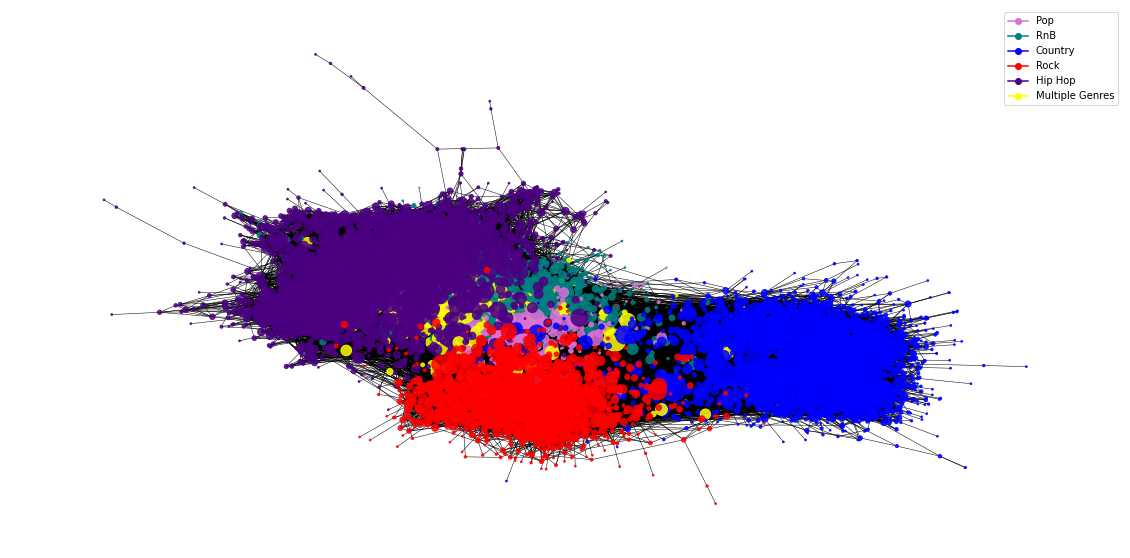

In [19]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(G, positions, node_size=deg_size, node_color=nodes_color, alpha=0.85)
nx.draw_networkx_edges(G, positions, width = 0.5)#, edge_color=edge_colors,width=0.5)

#adding legends to the network plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],marker='o', color='#DA70D6', label='Pop'),
                Line2D([0], [0], marker='o', color='#008080', label='RnB'),
                Line2D([0], [0], marker='o', color='blue', label='Country'),
                Line2D([0], [0], marker='o', color='red', label='Rock'),
                Line2D([0], [0],marker='o', color='#4B0082', label='Hip Hop'),
                Line2D([0], [0],marker='o', color='#FFFF00', label='Multiple Genres')]
plt.legend(handles=legend_elements, loc='upper right')

plt.axis('off')
#plt.savefig('big_net.png')
plt.show()

### Backbone analysis

In [20]:
# add weights when there are links in both directions
for node in sub_G:
    for ngbr in nx.neighbors(sub_G, node):
        if node in nx.neighbors(sub_G, ngbr):
            G.edges[node, ngbr]['weight'] = (
                G.edges[node, ngbr]['weight'] + G.edges[ngbr, node]['weight']
            )

https://github.com/aekpalakorn/python-backbone-network/blob/master/backbone.py 

In [21]:
from scipy import integrate

def disparity_filter(G, weight='weight'):
    ''' Compute significance scores (alpha) for weighted edges in G as defined in Serrano et al. 2009
        Args
            G: Weighted NetworkX graph
        Returns
            Weighted graph with a significance score (alpha) assigned to each edge
        References
            M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''
    
    if nx.is_directed(G): #directed case    
        N = nx.DiGraph()
        for u in G:
            
            k_out = G.out_degree(u)
            k_in = G.in_degree(u)
            
            if k_out > 1:
                sum_w_out = sum(np.absolute(G[u][v][weight]) for v in list(G.successors(u)))
                for v in list(G.successors(u)):
                    w = G[u][v][weight]
                    p_ij_out = float(np.absolute(w))/sum_w_out
                    alpha_ij_out = 1 - (k_out-1) * integrate.quad(lambda x: (1-x)**(k_out-2), 0, p_ij_out)[0]
                    N.add_edge(u, v, weight = w, alpha_out=float('%.4f' % alpha_ij_out))
                    
            elif k_out == 1 and G.in_degree(list(G.successors(u))[0]) == 1:
                #we need to keep the connection as it is the only way to maintain the connectivity of the network
                v = list(G.successors(u))[0]
                w = G[u][v][weight]
                N.add_edge(u, v, weight = w, alpha_out=0., alpha_in=0.)
                #there is no need to do the same for the k_in, since the link is built already from the tail
            
            if k_in > 1:
                sum_w_in = sum(np.absolute(G[v][u][weight]) for v in list(G.predecessors(u)))
                for v in list(G.predecessors(u)):
                    w = G[v][u][weight]
                    p_ij_in = float(np.absolute(w))/sum_w_in
                    alpha_ij_in = 1 - (k_in-1) * integrate.quad(lambda x: (1-x)**(k_in-2), 0, p_ij_in)[0]
                    N.add_edge(v, u, weight = w, alpha_in=float('%.4f' % alpha_ij_in))
        return N
    
    else: #undirected case
        B = nx.Graph()
        for u in G:
            k = len(G[u])
            if k > 1:
                sum_w = sum(np.absolute(G[u][v][weight]) for v in G[u])
                for v in G[u]:
                    w = G[u][v][weight]
                    p_ij = float(np.absolute(w))/sum_w
                    alpha_ij = 1 - (k-1) * integrate.quad(lambda x: (1-x)**(k-2), 0, p_ij)[0]
                    B.add_edge(u, v, weight = w, alpha=float('%.4f' % alpha_ij))
        return B

def disparity_filter_alpha_cut(G,weight='weight',alpha_t=0.4, cut_mode='or'):
    ''' Performs a cut of the graph previously filtered through the disparity_filter function.
        
        Args
        ----
        G: Weighted NetworkX graph
        
        weight: string (default='weight')
            Key for edge data used as the edge weight w_ij.
            
        alpha_t: double (default='0.4')
            The threshold for the alpha parameter that is used to select the surviving edges.
            It has to be a number between 0 and 1.
            
        cut_mode: string (default='or')
            Possible strings: 'or', 'and'.
            It works only for directed graphs. It represents the logic operation to filter out edges
            that do not pass the threshold value, combining the alpha_in and alpha_out attributes
            resulting from the disparity_filter function.
            
            
        Returns
        -------
        B: Weighted NetworkX graph
            The resulting graph contains only edges that survived from the filtering with the alpha_t threshold
    
        References
        ---------
        .. M. A. Serrano et al. (2009) Extracting the Multiscale backbone of complex weighted networks. PNAS, 106:16, pp. 6483-6488.
    '''       
    
    if nx.is_directed(G):#Directed case:   
        B = nx.DiGraph()
        for u, v, w in G.edges(data=True):
            try:
                alpha_in =  w['alpha_in']
            except KeyError: #there is no alpha_in, so we assign 1. It will never pass the cut
                alpha_in = 1
            try:
                alpha_out =  w['alpha_out']
            except KeyError: #there is no alpha_out, so we assign 1. It will never pass the cut
                alpha_out = 1  
            
            if cut_mode == 'or':
                if alpha_in<alpha_t or alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
            elif cut_mode == 'and':
                if alpha_in<alpha_t and alpha_out<alpha_t:
                    B.add_edge(u,v, weight=w[weight])
        return B

    else:
        B = nx.Graph()#Undirected case:   
        for u, v, w in G.edges(data=True):
            
            try:
                alpha = w['alpha']
            except KeyError: #there is no alpha, so we assign 1. It will never pass the cut
                alpha = 1
                
            if alpha<alpha_t:
                B.add_edge(u,v, weight=w[weight])
        return B                

In [22]:
alpha_val = [0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
number_nodes = []
number_edges = [] 
weights = []

#Calculating the total weight in the graph: 
G_backbone = disparity_filter(G)
print('original: nodes = %s, edges = %s' % (G_backbone.number_of_nodes(), G_backbone.number_of_edges()))
print('--------------------------------')
total_weight = 0
for u, v, d in G_backbone.edges(data=True):
    total_weight += d['weight']

for alpha in alpha_val:
    sum_weight = 0
    G2_backbone = nx.Graph([(u, v, d) for u, v, d in G_backbone.edges(data=True) if d['alpha'] < alpha ])
    print('alpha = %s' % alpha)
    print('backbone: nodes = %s, edges = %s' % (G2_backbone.number_of_nodes(), G2_backbone.number_of_edges()))
    number_nodes.append(G2_backbone.number_of_nodes())
    number_edges.append(G2_backbone.number_of_edges())
    for u, v, d in G2_backbone.edges(data=True):
        sum_weight += d['weight']
    weights.append(sum_weight)

original: nodes = 5942, edges = 57537
--------------------------------
alpha = 0.005
backbone: nodes = 1453, edges = 1113
alpha = 0.01
backbone: nodes = 1883, edges = 1594
alpha = 0.05
backbone: nodes = 3004, edges = 3557
alpha = 0.1
backbone: nodes = 3692, edges = 5152
alpha = 0.2
backbone: nodes = 4376, edges = 8612
alpha = 0.3
backbone: nodes = 4725, edges = 11963
alpha = 0.4
backbone: nodes = 5086, edges = 15797
alpha = 0.5
backbone: nodes = 5526, edges = 21850


In [108]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=[val / total_weight for val in weights], y=[val / G_backbone.number_of_nodes() for val in number_nodes],
    mode="lines+text",
    text=["&#x3B1;=0.005", "&#x3B1;=0.01", "&#x3B1;=0.05", "&#x3B1;=0.1", 
          "&#x3B1;=0.2", "&#x3B1;=0.3", "&#x3B1;=0.4", "&#x3B1;=0.5"],
    textposition="bottom center"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=[val / G_backbone.number_of_nodes() for val in number_nodes], x=[val / G_backbone.number_of_edges() for val in number_edges],
    mode="lines+text",
    text=["&#x3B1;=0.005", "&#x3B1;=0.01", "&#x3B1;=0.05", "&#x3B1;=0.1", 
          "&#x3B1;=0.2", "&#x3B1;=0.3", "&#x3B1;=0.4", "&#x3B1;=0.5"],
    textposition="bottom center"),
    row=1, col=2
)

# Update xaxis properties
fig.update_xaxes(title_text="W<sub>B</sub>/W<sub>T</sub>", row=1, col=1)
fig.update_xaxes(title_text="E<sub>B</sub>/E<sub>T</sub>", row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="N<sub>B</sub>/N<sub>T</sub>", row=1, col=1)
fig.update_yaxes(title_text="N<sub>B</sub>/N<sub>T</sub>", row=1, col=2)

# Update title and height
fig.update_layout(title_text="Nodes, edges and weight for different <i>&#x3B1;</i>-values", 
                 height=500, font_size=10, plot_bgcolor='rgba(0,0,0,0)',showlegend=False)

fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                     showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5)
pio.write_html(fig, file='alpha_vals.html', auto_open=False)

fig.show()

Table showing the sizes of the disparity backbones in terms of the percentage of total weight, nodes and edges for different values of the significance level $\alpha$. **SKAL ÆNDRES/Slettes**

| $$\alpha$$ | $$\%W_T$$ | $$\%N_T$$ | $$\%E_T$$ |
| ---   | ---  | ---  | ---  |
| 0.5   | 73.0 | 96.9 | 73.0 |
| 0.4   | 66.6 | 84.4 | 66.6 |
| 0.3   | 60.2 | 75.0 | 60.2 |
| 0.2   | 51.6 | 62.7 | 51.6 |
| 0.1   | 40.5 | 35.5 | 40.5  |
| 0.05  | 33.0  | 18.8 | 33.0  |
| 0.01  | 19.4  | 4.2  | 19.4  |
| 0.005 | 15.2  | 2.4  | 15.2  |
| 0.003 | 12.5  | 2.0  | 12.5  |

We continue with $\alpha=0.1$

In [24]:
alpha_val = 0.1
G2_backbone = nx.Graph([(u, v, d) for u, v, d in G_backbone.edges(data=True) if d['alpha'] < alpha_val ])
print('alpha = %s' % alpha_val)
print('original: nodes = %s, edges = %s' % (G_backbone.number_of_nodes(), G_backbone.number_of_edges()))
print('backbone: nodes = %s, edges = %s' % (G2_backbone.number_of_nodes(), G2_backbone.number_of_edges()))
#print(G2_backbone.edges(data=True))

alpha = 0.1
original: nodes = 5942, edges = 57537
backbone: nodes = 3692, edges = 5152


In [25]:
#only use this if we have a directed graph
for u, v, d in G_backbone.edges(data=True):
    if 'alpha_out' not in d: 
        d['alpha_out'] = 1
    if 'alpha_in' not in d: 
        d['alpha_in'] = 1

In [26]:
node_attr = df[['link_name','genre','origin','start_year','end_year']].set_index('link_name').to_dict('index') #Creating a dictionary with the characters and their attributes
nx.set_node_attributes(G2_backbone, node_attr) #Adding attributes to the graph

In [27]:
largest_cc = max(nx.connected_components(G2_backbone), key=len)
GCC_bb=G2_backbone.subgraph(largest_cc).copy()

In [28]:
values, counts = np.unique(list(nx.get_node_attributes(GCC_bb, 'genre').values()), return_counts=True)
plot_attribute_dist(values, counts)

In [29]:
pattern_flatten = re.compile(r'\w+')
flatten_list = pattern_flatten.findall(str(list(nx.get_node_attributes(GCC_bb, 'genre').values())))

values, counts = np.unique(flatten_list, return_counts=True)

plot_attribute_dist(values, counts)

## ANALYSIS

In [109]:
#Getting the top connected character (total-degree)
top_15 = sorted(GCC_bb.degree, key=lambda x: x[1], reverse=True)[:15]

In [112]:
#Creating a dataframe with top 20
names = []
for i in range(0,15): 
    name = top_20[i][0]
    names.append(name)

df_top15 = pd.DataFrame()
for name in names:
    df_top15 = df_top15.append(df.loc[df.link_name == name])

# Declares a list of the degrees is to be converted into a column
degrees = []
for i in range(0,15): 
    degree = top_15[i][1]
    degrees.append(degree)

# Using 'Total-degree' as the column name and equating it to the list
df_top15['Total_degree'] = degrees

In [116]:
output_notebook()
x = df_top15.Total_degree
genres = df_top15.genre
factors = df_top15.link_name.str.replace('_',' ')

fig = figure(title="Top 15 most connected artist/bands", toolbar_location=None,tools="hover", 
             tooltips="Degree: @x",plot_width=800, plot_height=500, 
             y_range=factors, x_range=[0,45])

fig.segment(0, factors, x, factors, line_width=2, line_color="#3182bd",
            hover_line_width=1)

cir= fig.circle(x, factors, size=15, fill_color="#9ecae1", line_color="#3182bd", line_width=3,
          hover_line_width=1)

fig.hover.renderers = [cir]

#fig.add_layout(labels)


fig.xgrid.grid_line_color = None
fig.ygrid.grid_line_color = None

show(fig, notebook_handle = True)

output_file('top_20.html', mode='inline')

Loading BokehJS ...

**Degree**

In [33]:
#total-degree distribution:
degrees_total = np.array(list(dict(GCC_bb.degree()).values()))
values, counts = np.unique(degrees_total, return_counts=True)

fig = px.line(x=values, y=counts, width=800, height=500)
fig.update_traces(hovertemplate=None)
fig.update_layout(title_text="degree distribution of backbone network", 
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis_title="Count",
                  xaxis_title="Degree",
                  hovermode="x unified")

fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()
#pio.write_html(fig, file='in_deg.html', auto_open=True)

**Plotting of backbone**

In [34]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2.0,

                        # Performance
                        jitterTolerance=1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1,
                        #multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=5,
                        strongGravityMode=False,
                        gravity=1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(GCC_bb, pos=None, iterations=100)

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 17.04it/s]

BarnesHut Approximation  took  1.81  seconds
Repulsion forces  took  3.83  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


In [35]:
#node size
d = dict(GCC_bb.degree)
deg_size = [v * 5 for v in d.values()]

In [36]:
print('backbone: nodes = %s, edges = %s' % (GCC_bb.number_of_nodes(), GCC_bb.number_of_edges()))

backbone: nodes = 2955, edges = 4701


In [37]:
nodes_color = []
    
for node in GCC_bb.nodes.data():
    if node[1]['genre'] == 'RnB':
        nodes_color.append('#008080')
    elif (node[1]['genre'] == 'Pop'):
        nodes_color.append('#DA70D6')
    elif (node[1]['genre'] == 'Country'):
        nodes_color.append('blue')
    elif (node[1]['genre'] == 'Rock'):
        nodes_color.append('red')
    elif (node[1]['genre'] == 'HipHop'):
        nodes_color.append('#4B0082')
    else:
        nodes_color.append('#FFFF00')

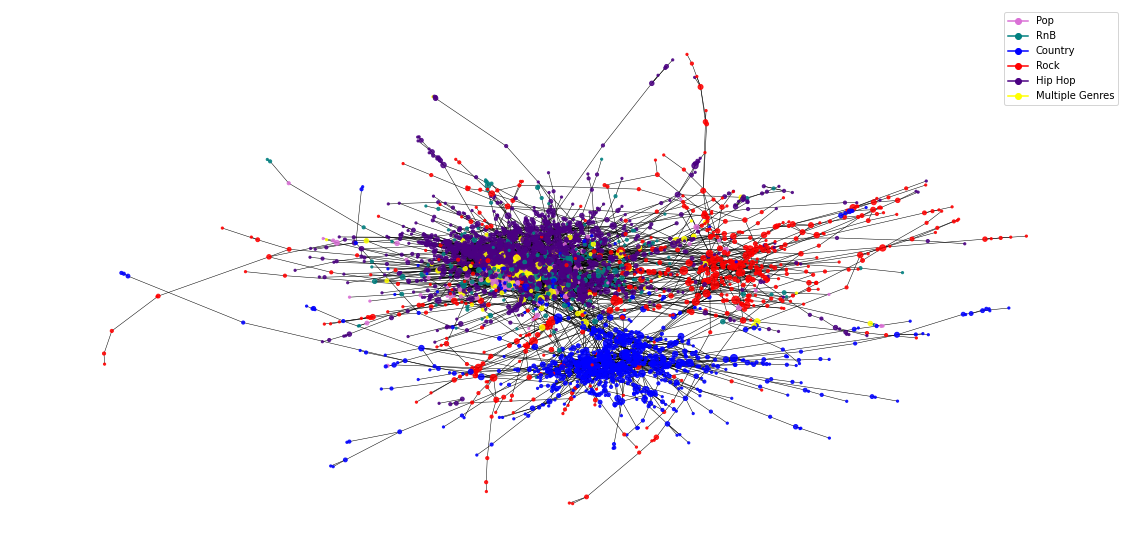

In [38]:
plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(GCC_bb, positions, node_size=deg_size, node_color=nodes_color, alpha=0.85)
nx.draw_networkx_edges(GCC_bb, positions, width = 0.5)#, edge_color=edge_colors,width=0.5)

#adding legends to the network plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],marker='o', color='#DA70D6', label='Pop'),
                Line2D([0], [0], marker='o', color='#008080', label='RnB'),
                Line2D([0], [0], marker='o', color='blue', label='Country'),
                Line2D([0], [0], marker='o', color='red', label='Rock'),
                Line2D([0], [0],marker='o', color='#4B0082', label='Hip Hop'),
                Line2D([0], [0],marker='o', color='#FFFF00', label='Multiple Genres')]
plt.legend(handles=legend_elements, loc='upper right')

plt.axis('off')
plt.savefig('Backbone.png')
plt.show()

### Communities

Identifying communities based on the Louvain method/algorithm

In [39]:
#Set seed
np.random.seed(1000)

# computing best community partition
partition = community.best_partition(GCC_bb)

# Get a set of the communities
communities = set(partition.values())

In [40]:
#Number of communities (+1 because community "0" also exist)
print('Number of communities:', max(partition.values())+1)

Number of communities: 38


In [41]:
L = GCC_bb.number_of_edges() #number of edges in the full network
M = 0 # initiating M

for i in range(0, max(partition.values())): #loop for all comminities
    com_list=[]
    for key, value in partition.items():
        df.loc[df.link_name == key, 'community'] = value #creating new column in orig. dataframe
        if value == i: #check if community in partition is equal to the community we are looking at currently
            com_list.append(key) 
    subG = GCC_bb.subgraph(com_list).copy() #subgraph of community
    L_c = subG.number_of_edges() #edges in subgrpah
    k_c = sum([subG.degree(n) for n in subG.nodes()]) #sum of degrees in subgraph
    
    #computing M
    M +=  L_c/L-(k_c/(2*L))**2 

print('Modularity of Backbone GCC:', np.round(M,3))

Modularity of Backbone GCC: 0.76


In [42]:
import heapq
#Rename communities

#Find largest degree nodes in each com.
communities_dict = {c: [k for k, v in partition.items() if v == c] for c in communities}
highest_degree = {k: heapq.nlargest(3, v, key=lambda x: GCC_bb.degree(x)) for k, v in communities_dict.items()}

#Add column to community dataframe with community names
for key, values in highest_degree.items():
    df.loc[df.community == key, 'com_name'] = ", ".join(values).replace('_',' ') 

In [43]:
plot_df = df[df.community.isna()==False].groupby(['com_name','genre'])['name'].count()
plot_df = plot_df.unstack(1).fillna(0)
plot_df['Multiple Genres'] = plot_df.drop(['Pop','RnB','HipHop','Country','Rock'],axis=1).sum(axis=1)
plot_df['total'] = plot_df.drop('Multiple Genres',axis=1).sum(axis=1)
plot_df = plot_df[['Pop','RnB','HipHop','Country',
                   'Rock','Multiple Genres','total']].sort_values(by='total',ascending=False)

In [44]:
fig = px.bar(plot_df, x=plot_df.index, y=['Pop','RnB','HipHop','Country','Rock','Multiple Genres'], width=800, 
             height=500, color_discrete_sequence=["#DA70D6", "#008080", "#4B0082", "blue", "red",'#FFFF00'])
fig.update_traces(hovertemplate=None)
fig.update_layout(title_text="Community sizes", 
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis_title="Count",
                  xaxis_title='',
                  hovermode="x unified",
                  font=dict(size=6))

fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.show()
pio.write_html(fig, file='com_size.html', auto_open=False)

In [91]:
df_com=df[df.com_name.isna()==False]

#Country
set1=set(df_com[df_com.com_name.str.contains('Elvis')].link_name.values)
set2=set(df_com[df_com.com_name.str.contains('Emmylou')].link_name.values)
set3=set(df_com[df_com.com_name.str.contains('Taylor Swift')].link_name.values)

#Rock
set4=set(df_com[df_com.com_name.str.contains('Nirvana')].link_name.values)
set5=set(df_com[df_com.com_name.str.contains('Marr')].link_name.values)
set6=set(df_com[df_com.com_name.str.contains('Alanis')].link_name.values)

#Pop/Rnb/variety
set7=set(df_com[df_com.com_name.str.contains('Nicki')].link_name.values)
set8=set(df_com[df_com.com_name.str.contains('Michael Jackson')].link_name.values)
set9=set(df_com[df_com.com_name.str.contains('Pussycat')].link_name.values)

#Hiphop
set10=set(df_com[df_com.com_name.str.contains('Eminem')].link_name.values)
set11=set(df_com[df_com.com_name.str.contains('Kanye')].link_name.values)
set12=set(df_com[df_com.com_name.str.contains('XXX')].link_name.values)

In [64]:
com1_G=GCC_bb.subgraph(set1).copy()
com2_G=GCC_bb.subgraph(set2).copy()
com3_G=GCC_bb.subgraph(set3).copy()
com4_G=GCC_bb.subgraph(set4).copy()
com5_G=GCC_bb.subgraph(set5).copy()
com7_G=GCC_bb.subgraph(set7).copy()
com8_G=GCC_bb.subgraph(set8).copy()
com9_G=GCC_bb.subgraph(set9).copy()
com10_G=GCC_bb.subgraph(set10).copy()
com11_G=GCC_bb.subgraph(set11).copy()
com12_G=GCC_bb.subgraph(set12).copy()

c = nx.union(com1_G,com3_G)
c = nx.union(c,com4_G)
c = nx.union(c,com7_G)
c = nx.union(c,com8_G)
c = nx.union(c,com10_G)
c = nx.union(c,com11_G)

In [106]:
#PyVis plot

net = Network(height='500px', width='100%', bgcolor='white', font_color='black',notebook=True)

net.from_nx(c)
neighbors = net.get_adj_list()
#net.force_atlas_2based()

for node in net.nodes:
    node['value'] = len(neighbors[node['id']])
    genre = df.loc[df.link_name==node['id']]['genre'].values
    #print(node)
    if genre == 'RnB':
        node['color'] = '#008080'
    elif genre == 'Pop':
        node['color'] = '#DA70D6'
    elif genre == 'Country':
        node['color']='blue'
    elif genre == 'Rock':
        node['color']='red'
    elif genre == 'HipHop' :
        node['color']='#4B0082'
    else:
        node['color']='#FFFF00'
    node['label'] = node['label'].replace('_', ' ')

net.show('test_com.html')

In [63]:
plot_df=df[df.link_name.isin(set1|set3|set7|set8|set10|set11|set12)&(df.start_year!='Unknown')].\
    groupby(['com_name','start_year'])['name'].count()
plot_df.index.names = ["Community", "Start Year"]
plot_df = plot_df.unstack(0)
plot_df = plot_df.fillna(0)
plot_df.index=plot_df.index.astype(int)
plot_df = plot_df.reindex(list(range(plot_df.index.min(),plot_df.index.max()+1)),fill_value=0)

In [61]:
plot_df=plot_df[['Carrie Underwood, Reba McEntire, Taylor Swift','Johnny Cash, Willie Nelson, Elvis Presley',
    'Eminem, Dr. Dre, Snoop Dogg','Kanye West, Drake (musician), Rihanna','XXXTentacion, Lil Durk, Juice Wrld',
    'Mariah Carey, Whitney Houston, Michael Jackson','Nicki Minaj, Chris Brown, Beyoncé']]

In [62]:
colors = ['#B2BEB5','#818589',"#89CFF0","#0096FF","#5F9EA0",'#40B5AD','#097969','#355E3B']

fig = px.scatter(plot_df, x=plot_df.index, y=plot_df.columns, width=800, height=500, 
              color_discrete_sequence = colors)
fig.update_traces(hovertemplate=None,fill='tozeroy',mode='lines')
fig.update_layout(title_text="Start year of artists in selected communities", 
                  plot_bgcolor='rgba(0,0,0,0)',
                  yaxis_title="Count",
                  hovermode="x unified",
                  font=dict(size=7))
fig.update_xaxes(showline=True, linewidth=1, linecolor='lightgrey', 
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showline=True, linewidth=1, linecolor='lightgrey',
                 showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()
#pio.write_html(fig, file='com_year.html', auto_open=False)

In [69]:
import cartopy.crs as ccrs

In [98]:
# 
pos_dict1=df[df.link_name.isin(set5)].set_index('link_name')[['lon','lat']].agg(tuple, 1).to_dict()
pos_dict2=df[df.link_name.isin(set6)].set_index('link_name')[['lon','lat']].agg(tuple, 1).to_dict()

map_G1 = GCC_bb.subgraph(list(pos_dict1.keys()))
map_G2 = GCC_bb.subgraph(list(pos_dict2.keys()))

/var/folders/99/scf2x63d4gsdly65b8zzk2vh0000gn/T/ipykernel_990/2814084138.py:28: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



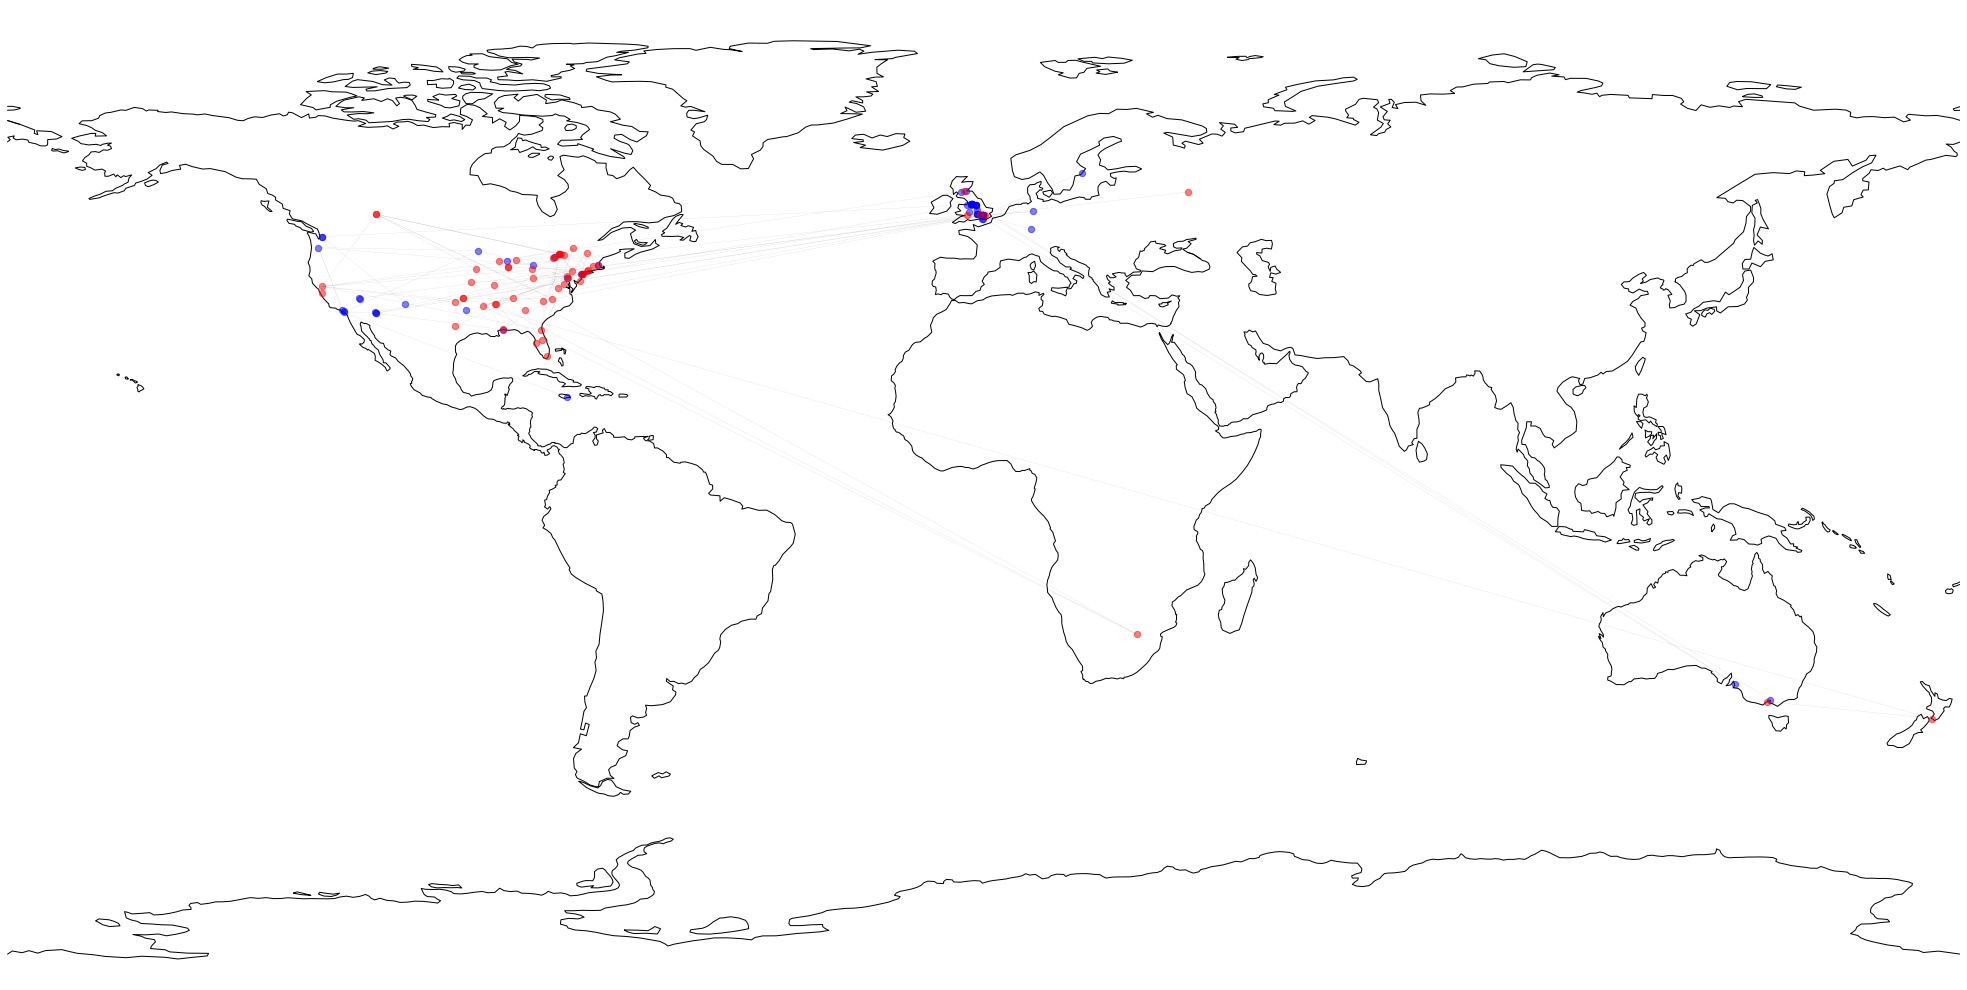

In [101]:
# Map projection

crs = ccrs.PlateCarree(central_longitude=0)
fig, ax = plt.subplots(1, 1, figsize=(35, 20), subplot_kw=dict(projection=crs))
ax.coastlines()
ax.set_global()

nx.draw(map_G1, ax=ax,
                 font_size=2,
                 alpha=.5,
                 width=.075,
                 node_size=40,
                 #labels=False,
                 pos=pos_dict1,
                 node_color='blue',
                 cmap=plt.cm.autumn)
nx.draw(map_G2, ax=ax,
                 font_size=2,
                 alpha=.5,
                 width=.075,
                 node_size=40,
                 #labels=False,
                 pos=pos_dict2,
                 node_color='red',
                 cmap=plt.cm.autumn)

fig.savefig('map_rock.png')
fig.show()

**Community plotting**

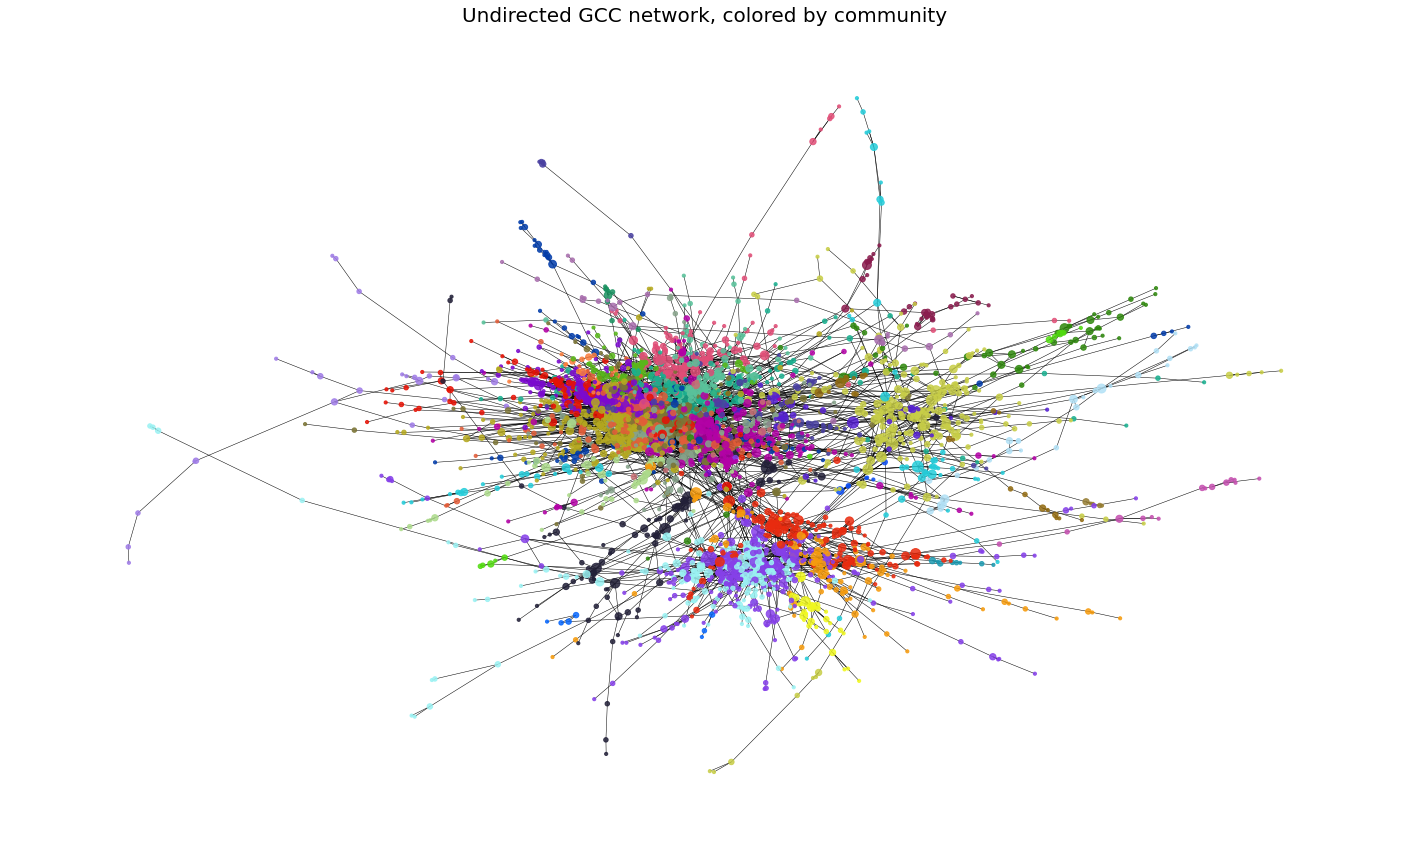

In [102]:
#Generate colors
color = []
n = 100 
for i in range(n):
    color.append('#%06X' % randint(0, 0xFFFFFF))

color_list = []
for i in list(partition.values()):
    color_list.append(color[i])  #append color to communities

d = dict(GCC_bb.degree)
deg_size = [v * 10 for v in d.values()]

#plot network
plt.figure(figsize=(25,15))
nx.draw_networkx_nodes(GCC_bb, positions, node_size=deg_size, node_color=color_list, alpha=0.85)
nx.draw_networkx_edges(GCC_bb, positions, width=0.5)#edge_color=edge_colors
plt.title("Undirected GCC network, colored by community", fontsize=20)
plt.axis('off')
plt.show()

**Network analysis outcomes**

## Sentiment Analysis

### Sentiment analysis goal

The purpose of sentiment analysis in our study is to get insight into the emotional part of the songs. We start by looking at the overall picture and investigate the distribution of sentiment, revealing wheather the top listen songs provides a positive or negative message. To get a deeper insight we investigate the sentiment for each genre to see if some genre is more violent/negative than others. In the end we look into the most positive and negative songs and what words discribes the sentiment groups to understand what makes a song negative. Hopefully this part of our study will provide knowledge of the emotional state of song and how the genres differents on thir sentiment.

### Sentiment tool

Sentiment analysis is a machine learning technique capable of understanding the tone that underlie a text and thus classify the spoken human language as positive, neutral or negative. When analysing language data, a model should ideally take linguistics, word ambiguity, negation, capitalization, emojis, context, symbolism and sarcasm into account to capture meaningful microsignals within language patterns and subsequently determine the relative positivity or negativity of written text. An example of how the sentiment analysis should be able to capture negations can be seen in the sentence ”I do not like you” the word like is treated as a positive verb however, due to the linguistic structure, the proceeding phrase "I do not" yields negation of like, hence a negative sentence polarity.

There exist multiple sentiment analysis models, all for different purpose and each with their stregnth and weaknesses. Due to the often extream word used in songs the choosen model is Vader. Vader(Valence Aware Dictionary for Sentiment Reasoning), is trained on social media data and is thus naturally attuned to sentiments expressed in this context, including both polarity, intensity (”!!!”), emoticons (”:-/”), acronyms (”LOL”) and slang. The model relies on word-order relationship, i.e. classifying based on full sentence structure. The Vader sentiment model calculates and returns the probability of a given input text to be positive, negative, and neutral. For example:“The song is great!” gives the score: positive= 0.9, neutral = 0.1 and negative = 0. These three probabilities will always add up to 1. Furthermore the Vader sentiment calculates a compound score which is an aggregated normalized score with −1 being the most negative and +1 the most positive. To classify a song as positive, neutral or negative the Vader sentiment model provides a threshold on the compound score, see The Vader Sentiment Model github page for detailed describtion of the model and the thresholds. For this study we use the Vader sentiment classification which are as followed:

positive: compound >=0.5 
neutral: -0.5 < compound < 0.5 
negative: compound=<-0.5 

### Get Data

**Load artist**

Only artist that are represented in genius

In [ ]:
df = pd.read_csv('./sentiment.allartist.csv', index_col=0)
df.head()

name genre     allgenre   link_name                 origin  \
0     Aaliyah   RnB  RnB, HipHop     Aaliyah          New York City   
1       Adele   RnB          RnB       Adele                 London   
2     After 7   RnB          RnB     After_7  Indianapolis, Indiana   
3  Jhené Aiko   RnB  RnB, HipHop  Jhené_Aiko            Los Angeles   
4        Akon   RnB  RnB, HipHop        Akon    St. Louis, Missouri   

                                        years_active start_year end_year  \
0                    1989\u20132001\n| relatives           1989     2001   
1           2006\u2013present\n| spouse                    2006  Present   
2   1987\u20131997; 2006\u2013present\n| label   ...       1987  Present   
3              2002\u2013present\n| label                  2002  Present   
4           1996\u2013present\n| module                    1996  Present   

   degree  
0     4.0  
1     5.0  
2     0.0  
3     3.0  
4    12.0

In [ ]:
len(df)

6436

Each song should represent one genre. We will therefore only allow each artist to represent one genre. 

In [ ]:
df=df.drop_duplicates(subset=['link_name'])

In [ ]:
len(df)

6261

Top 50 artist within each genre has been extracted. This is based on the degree for each artist from the network analysis.

In [ ]:
top50=df.groupby('genre').apply(lambda x: x.nlargest(50, 'degree')).reset_index(drop=True)
top50

name    genre allgenre  \
0                 Emmylou Harris  Country  Country   
1                  Willie Nelson  Country  Country   
2                    Johnny Cash  Country  Country   
3                   Dolly Parton  Country  Country   
4               Carrie Underwood  Country  Country   
..                           ...      ...      ...   
245               Incubus (band)     Rock     Rock   
246             Jane's Addiction     Rock     Rock   
247              John Frusciante     Rock     Rock   
248  Jon Spencer Blues Explosion     Rock     Rock   
249                  The Killers     Rock     Rock   

                       link_name                     origin  \
0                 Emmylou_Harris        Birmingham, Alabama   
1                  Willie_Nelson              Abbott, Texas   
2                    Johnny_Cash        Kingsland, Arkansas   
3                   Dolly_Parton  Pittman Center, Tennessee   
4               Carrie_Underwood         Muskogee, Oklahoma   
..                           ...                        ...   
245               Incubus_(band)      Calabasas, California   
246             Jane's_Addiction                Los Angeles   
247              John_Frusciante                     Queens   
248  Jon_Spencer_Blues_Explosion              New York City   
249                  The_Killers                  Las Vegas   

                                          years_active start_year end_year  \
0               1969\u2013present\n| label                   1969  Present   
1             1956\u2013present\n| spouse                    1956  Present   
2                1954\u20132003\n| spouse                    1954     2003   
3             1956\u2013present\n| awards                    1956  Present   
4             2005\u2013present\n| awards                    2005  Present   
..                                                 ...        ...      ...   
245             1991\u2013present\n| label                   1991  Present   
246   {{flatlist|\n* {{Start date|1985}}\u20131991\...       1985  Present   
247             1988\u2013present\n| label                   1988  Present   
248                 1991\u20132016<ref>{{Cite web |url       1991     2016   
249             2001\u2013present\n| label                   2001  Present   

     degree  
0      24.0  
1      17.0  
2      12.0  
3      12.0  
4      11.0  
..      ...  
245     3.0  
246     3.0  
247     3.0  
248     3.0  
249     3.0  

[250 rows x 9 columns]

In [ ]:
top50.to_csv('top50.csv')

In [ ]:
top50 = pd.read_csv('top50.csv')

**Get lyrics**

We use genius API to extract each artist most listen to song.This song will represent the artist. 

In [ ]:
import lyricsgenius as genius
geniusCreds = "aCQh7LLS717JOZEveiE1-Vc6ifPi6V0ZVmHNf2BAc7xMjfaWXVVO3Ce1t8X2VqmG"

In [ ]:
liste=[]
pattern = '(\(.*?\))'
path = "./top50/"
api = genius.Genius(geniusCreds)
for i in top50.name:
    try:
        remove_parentese = re.findall(pattern, i)
        remove=''.join(remove_parentese)
        i = i.replace(remove, '')
        artist = api.search_artist(i, max_songs=1)
        artist.save_lyrics()
    except:
        liste.append(i)
        pass
    
    


Searching for songs by Emmylou Harris...

Song 1: "Didn’t Leave Nobody But The Baby"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_EmmylouHarris.json.
Searching for songs by Willie Nelson...

Song 1: "Cruel World"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_WillieNelson.json.
Searching for songs by Johnny Cash...

Song 1: "You Are My Sunshine"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_JohnnyCash.json.
Searching for songs by Dolly Parton...

Song 1: "Jolene"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_DollyParton.json.
Searching for songs by Carrie Underwood...

Song 1: "Before He Cheats"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_CarrieUnderwood.json.
Searching for songs by George Jones...

Song 1: "He Stopped Loving Her Today"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_GeorgeJones.json.
Searching for songs

Song 1: "Find My Love"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_SalaamRemi.json.
Searching for songs by Dr. Dre...

Song 1: "Forgot About Dre"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_Dr.Dre.json.
Searching for songs by Eminem...

Song 1: "Rap God"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_Eminem.json.
Searching for songs by Lil Wayne...

Song 1: "Love Me"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_LilWayne.json.
Searching for songs by T.I....

Song 1: "About The Money"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_T.I..json.
Searching for songs by Travis Scott ...

Changing artist name to 'Travis Scott'
Song 1: "SICKO MODE"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_TravisScott.json.
Searching for songs by 50 Cent...

Song 1: "In da Club"

Reached user-specified song limit (1).
Done. Found 1 songs.
W

Song 1: "1999"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_Prince.json.
Searching for songs by Timbaland...

Song 1: "The Way I Are"

Reached user-specified song limit (1).
Done. Found 1 songs.
Lyrics_Timbaland.json already exists. Overwrite?
(y/n): n
Skipping file save.

Searching for songs by Janet Jackson...

Song 1: "No Sleeep"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_JanetJackson.json.
Searching for songs by Justin Bieber...

Song 1: "Love Yourself"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_JustinBieber.json.
Searching for songs by Avicii...

Song 1: "Wake Me Up"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_Avicii.json.
Searching for songs by David Guetta...

Song 1: "2U"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_DavidGuetta.json.
Searching for songs by Kesha...

Song 1: "Praying"

Reached user-specified song limit (1).
Done. F

Lyrics_JustinTimberlake.json already exists. Overwrite?
(y/n): n
Skipping file save.

Searching for songs by Beyoncé...

Song 1: "Drunk in Love"

Reached user-specified song limit (1).
Done. Found 1 songs.
Lyrics_Beyoncé.json already exists. Overwrite?
(y/n): n
Skipping file save.

Searching for songs by Ariana Grande...

Song 1: "​thank u, next"

Reached user-specified song limit (1).
Done. Found 1 songs.
Lyrics_ArianaGrande.json already exists. Overwrite?
(y/n): n
Skipping file save.

Searching for songs by Prince ...

Changing artist name to 'Prince'
Song 1: "1999"

Reached user-specified song limit (1).
Done. Found 1 songs.
Lyrics_Prince.json already exists. Overwrite?
(y/n): n
Skipping file save.

Searching for songs by Janet Jackson...

Song 1: "No Sleeep"

Reached user-specified song limit (1).
Done. Found 1 songs.
Lyrics_JanetJackson.json already exists. Overwrite?
(y/n): n
Skipping file save.

Searching for songs by Pharrell Williams...

Song 1: "Happy"

Reached user-specified

Song 1: "Nutshell"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_AliceinChains.json.
Searching for songs by Avril Lavigne...

Song 1: "Complicated"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_AvrilLavigne.json.
Searching for songs by Beastie Boys...

Song 1: "Intergalactic"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_BeastieBoys.json.
Searching for songs by Chester Bennington...

Searching for songs by The Cribs...

Song 1: "Be Safe"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_TheCribs.json.
Searching for songs by Depeche Mode...

Song 1: "Enjoy the Silence"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_DepecheMode.json.
Searching for songs by Eddie Vedder...

Song 1: "Guaranteed"

Reached user-specified song limit (1).
Done. Found 1 songs.
Wrote Lyrics_EddieVedder.json.
Searching for songs by Linkin Park...

Song 1: "In the End"

Reached use

In [ ]:
pattern = '(\(.*?\))'
path = "./top50/"
with open(path+'Lyrics_NickiMinaj.json') as json_data:
        data = json.load(json_data)
        a = pd.DataFrame(data['songs'])



In [ ]:

for i in range(len(top50.link_name)):
    remove_parentese = re.findall(pattern, top50['link_name'][i])
    remove=''.join(remove_parentese)
    top50['link_name'][i] = top50['link_name'][i].replace(remove, '')


/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/833297706.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50['link_name'][i] = top50['link_name'][i].replace(remove, '')


In [ ]:
top50['link_name2']=top50['link_name'].replace('_', '', regex=True)
song = pd.DataFrame(columns=[col for col in a.columns])
for i in top50.link_name2:
    with open(path+'Lyrics_'+i+'.json') as json_data:
        data = json.load(json_data)
        df1 = pd.DataFrame(data['songs'])
        song=pd.concat([song,df1])

In [ ]:
song2=song[['artist','artist_names','title','release_date','lyrics']].reset_index()

In [ ]:
result = pd.concat([top50, song2], axis=1)
song=result.copy()

In [ ]:
song.tail(3)

Unnamed: 0                         name genre allgenre  \
247         247              John Frusciante  Rock     Rock   
248         248  Jon Spencer Blues Explosion  Rock     Rock   
249         249                  The Killers  Rock     Rock   

                       link_name         origin  \
247              John_Frusciante         Queens   
248  Jon_Spencer_Blues_Explosion  New York City   
249                  The_Killers      Las Vegas   

                                years_active start_year end_year  degree  \
247   1988\u2013present\n| label                   1988  Present     3.0   
248       1991\u20132016<ref>{{Cite web |url       1991     2016     3.0   
249   2001\u2013present\n| label                   2001  Present     3.0   

                   link_name2  index                           artist  \
247            JohnFrusciante      0                  John Frusciante   
248  JonSpencerBluesExplosion      0  The Jon Spencer Blues Explosion   
249                TheKillers      0                      The Killers   

                        artist_names              title release_date  \
247                  John Frusciante  The Will to Death   2004-06-22   
248  The Jon Spencer Blues Explosion        Bellbottoms   1994-10-12   
249                      The Killers     Mr. Brightside   2003-09-29   

                                                lyrics  
247  [Verse 1]\nAnd they're thought to be lies, but...  
248  [Intro]\n(Hey!) Yeah, ha ha\n(Hey!) Like that ...  
249  [Verse 1]\nComing out of my cage and I've been...

### Sentiment Analysis

In [ ]:
song['Negative']=''
song['Neutral']=''
song['Positive']=''
song['Compound']=''

In [ ]:
analyzer = SentimentIntensityAnalyzer()

for i, text in song.iterrows():
    song['Negative'][i]=analyzer.polarity_scores(text['lyrics'])['neg']
    song['Neutral'][i]=analyzer.polarity_scores(text['lyrics'])['neu']
    song['Positive'][i]=analyzer.polarity_scores(text['lyrics'])['pos']
    song['Compound'][i]=analyzer.polarity_scores(text['lyrics'])['compound']

/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/2274514424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song['Negative'][i]=analyzer.polarity_scores(text['lyrics'])['neg']
/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/2274514424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song['Neutral'][i]=analyzer.polarity_scores(text['lyrics'])['neu']
/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/2274514424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.o

In [ ]:
song.dtypes

Unnamed: 0        int64
name             object
genre            object
allgenre         object
link_name        object
origin           object
years_active     object
start_year       object
end_year         object
degree          float64
link_name2       object
index             int64
artist           object
artist_names     object
title            object
release_date     object
lyrics           object
Negative         object
Neutral          object
Positive         object
Compound         object
dtype: object

In [ ]:
song[['Compound','Negative','Neutral','Positive']] = song[['Compound','Negative','Neutral','Positive']].astype('float64')

In [ ]:
song['Sentiment']=''
for i, score in song.iterrows():
    if score['Compound'] >=0.5:   #positive threshold
        song['Sentiment'][i] = 'Positive'
    elif score['Compound']<=-0.5: #negative threshold
        song['Sentiment'][i] = 'Negative' 
    else:
        song['Sentiment'][i] = 'Neutral'

/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/1564882925.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song['Sentiment'][i] = 'Positive'
/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/1564882925.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song['Sentiment'][i] = 'Negative'
/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/1564882925.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [ ]:
song.to_csv('Sentiment.csv')

In [ ]:
song=pd.read_csv('Sentiment.csv')

In [ ]:
len(song)

250

In [ ]:
song.head(3)

Unnamed: 0  Unnamed: 0.1            name    genre allgenre       link_name  \
0           0             0  Emmylou Harris  Country  Country  Emmylou_Harris   
1           1             1   Willie Nelson  Country  Country   Willie_Nelson   
2           2             2     Johnny Cash  Country  Country     Johnny_Cash   

                origin                               years_active start_year  \
0  Birmingham, Alabama     1969\u2013present\n| label                   1969   
1        Abbott, Texas   1956\u2013present\n| spouse                    1956   
2  Kingsland, Arkansas      1954\u20132003\n| spouse                    1954   

  end_year  ...          artist  \
0  Present  ...  Emmylou Harris   
1  Present  ...   Willie Nelson   
2     2003  ...     Johnny Cash   

                                        artist_names  \
0  Emmylou Harris (Ft. Alison Krauss & Gillian We...   
1                                      Willie Nelson   
2                                        Johnny Cash   

                              title release_date  \
0  Didn’t Leave Nobody But The Baby   2000-12-05   
1                       Cruel World   2019-07-12   
2               You Are My Sunshine   1989-11-25   

                                              lyrics Negative Neutral  \
0  Go to sleep, you little baby\n(Go to sleep, yo...    0.076   0.775   
1  [Chorus]\nCruel, cruel world, must I go on?\nC...    0.378   0.592   
2  [Verse 1]\nThe other night dear, as I lay slee...    0.101   0.601   

  Positive  Compound  Sentiment  
0    0.149    0.9523   Positive  
1    0.030   -0.9992   Negative  
2    0.297    0.9879   Positive  

[3 rows x 23 columns]

In [ ]:
song[['title','artist','genre','Compound']].nlargest(5, 'Compound')

title             artist   genre  Compound
112  Girls Like You (Remix)           Maroon 5     Pop    0.9999
160                 Mirrors  Justin Timberlake     RnB    0.9999
162          ​thank u, next      Ariana Grande     RnB    0.9998
96                Self Care         Mac Miller  HipHop    0.9997
132     Lose You To Love Me       Selena Gomez     Pop    0.9997

In [ ]:
song[['title','artist','genre','Compound']].nsmallest(5, 'Compound')

title          artist    genre  Compound
69          HUMBLE.  Kendrick Lamar   HipHop   -0.9997
144    Cruel Summer      Bananarama      Pop   -0.9996
68   No Role Modelz         J. Cole   HipHop   -0.9994
172   Dirty Laundry   Kelly Rowland      RnB   -0.9993
1       Cruel World   Willie Nelson  Country   -0.9992

In [ ]:
positive_song=song[song['Sentiment']=='Positive']
neutral_song=song[song['Sentiment']=='Neutral']
negative_song=song[song['Sentiment']=='Negative']

print("Total number of songs:", len(song))
count_neg_song=len(negative_song)
count_neu_song=len(neutral_song)
count_pos_song=len(positive_song)
print("Number of negative songs:", count_neg_song)
print("Number of neutral songs:", count_neu_song)
print("Number of positive songs:", count_pos_song)

Total number of songs: 250
Number of negative songs: 78
Number of neutral songs: 8
Number of positive songs: 164


**Plot sentiment distribution**

In [ ]:
import plotly.graph_objects as go
from plotly.offline import iplot

colors = ['forestgreen', 'gold', 'indianred', 'white']

labels = 'Positive', 'Neutral', 'Negative'
values = [count_pos_song, count_neu_song, count_neg_song]


fig = go.Figure(data=[go.Pie(labels=labels, values=values)])

fig.update_traces(hoverinfo='label+value',textfont_size=14, 
                  marker=dict(colors=colors,line=dict(color='#ffffff', width=6)))

fig.update_layout(title='Sentiment class distribution',title_x=0.5, legend=dict(
        x=1.0,
        y=0.5,
        
    ))




config = {'displayModeBar': False}
fig.write_html('sentimentpiechart.html',config =config  )
iplot(fig)

In [ ]:
import plotly.express as px
fig2 = px.histogram(song, x="Compound", nbins=20, hover_name='Compound',labels={'Sentiment':''}, title='Sentiment score distribution',color='Sentiment', color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'
    })

fig2.update_layout(title_x=0.5,legend=dict(
        x=1.0,
        y=0.5,
        
    ))
#fig.update_traces(hoverinfo='name')

#fig.update_xaxes(range=[-1, 1]) xyz name text

config = {'displayModeBar': False}

fig2.show(config=config)

fig2.write_html('compound.html', config=config)

### Sentiment pr genre

In [ ]:
song.groupby('genre').count()

Unnamed: 0  Unnamed: 0.1  name  allgenre  link_name  origin  \
genre                                                                  
Country          50            50    50        50         50      50   
HipHop           50            50    50        50         50      50   
Pop              50            50    50        50         50      50   
RnB              50            50    50        50         50      50   
Rock             50            50    50        50         50      50   

         years_active  start_year  end_year  degree  ...  artist  \
genre                                                ...           
Country            50          50        50      50  ...      50   
HipHop             50          50        50      50  ...      50   
Pop                50          50        50      50  ...      50   
RnB                50          50        50      50  ...      50   
Rock               50          50        50      50  ...      50   

         artist_names  title  release_date  lyrics  Negative  Neutral  \
genre                                                                   
Country            50     50            34      50        50       50   
HipHop             50     50            47      50        50       50   
Pop                50     50            47      50        50       50   
RnB                50     50            46      50        50       50   
Rock               50     50            48      50        50       50   

         Positive  Compound  Sentiment  
genre                                   
Country        50        50         50  
HipHop         50        50         50  
Pop            50        50         50  
RnB            50        50         50  
Rock           50        50         50  

[5 rows x 22 columns]

In [ ]:
test=song.groupby(['genre','Sentiment']).count().reset_index()
test2=test[['genre','Sentiment','title']]
test2['title']=test2['title']*2
test2

/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/3978565152.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



genre Sentiment  title
0   Country  Negative     14
1   Country   Neutral     10
2   Country  Positive     76
3    HipHop  Negative     60
4    HipHop   Neutral      2
5    HipHop  Positive     38
6       Pop  Negative     20
7       Pop   Neutral      2
8       Pop  Positive     78
9       RnB  Negative     16
10      RnB   Neutral      2
11      RnB  Positive     82
12     Rock  Negative     46
13     Rock  Positive     54

In [ ]:
import plotly.express as px

long_df = test2

fig = px.bar(long_df, x="genre", y="title", color="Sentiment", title="Sentiment distribution pr genre",
             labels={'title':'%','Sentiment':''}, color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'
    })
for data in fig.data:
    data["width"] = 0.6 #Change this value for bar widths


fig.update_layout(title_x=0.5, legend=dict(
        x=1.0,
        y=0.5,
        
    ))


config = {'displayModeBar': False}


fig.show(config=config)

fig.write_html('sentimentgenre.html', config=config)



As expected Hip Hop has the most negative songs.

In [ ]:
song=pd.read_csv('Sentiment.csv')

## Topic Modeling

In [ ]:
vocab_size = []

from functools import reduce
def lyrics_to_lists(df, columns):
    #https://stackoverflow.com/questions/39291499/how-to-concatenate-multiple-column-values-into-a-single-column-in-panda-datafram
    slist = [df[x].astype(str) for x in columns]
    client_comments=reduce(lambda x, y: x + ' ' + y, slist[1:], slist[0])
    return client_comments


def lyrics_to_doc(df, columns):
    client_comments = lyrics_to_lists(df,columns)
    return client_comments.str.cat(sep=' ')


def top_n_words(split_doc,n):
    # Pass the split_it list to instance of Counter class.
    from collections import Counter
    Counter = Counter(split_doc) 

    # most_common() produces k frequently encountered  
    most_occur = Counter.most_common(n)
    return most_occur

In [ ]:
vocab=len(set(lyrics_to_doc(song,['lyrics']).split()))
vocab_size.append(('Raw text',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  12647


In [ ]:
print('Corpus size: ', len(lyrics_to_doc(song,['lyrics']).split()))

Corpus size:  114406


In [ ]:
n=10
doc = lyrics_to_doc(song,['lyrics']).split() 
top_n_words(doc,n)

[('I', 3813),
 ('the', 3420),
 ('you', 3015),
 ('a', 2082),
 ('to', 1950),
 ('my', 1707),
 ('me', 1512),
 ('and', 1300),
 ('in', 1234),
 ('it', 1216)]

As expected the top 10 used words says nothing about the lyrcis. We thereby clean the data (and reduce the vocabulary size).

**Cleaning data**

In [ ]:
# Expand typical contractions and labeling options futures products to distinguish from common 'option' and 'future'. 
contractions = {"ain't": "am not",
                "'cause": "because",
                "could've": "could have",
                "didnt": "did not",
                "hadnt": "had not",
                "haven't": "have not",
                "havent": "have not",
                "how'd": "how did",
                "how'll": "how will",
                "it'd": "it would",
                "it'll": "it will",
                "mayn't": "may not",
                "might've": "might have",
                "mightn't": "might not",
                "must've": "must have",
                "mustn't": "must not",
                "needn't": "need not",
                "oughtn't": "ought not",
                "shan't": "shall not",
                "should've": "should have",
                "shouldnt": "should not",
                "that'd": "that would",
                "there'd": "there would",
                "theres": "there is",
                "wasn't": "was not",
                "wasnt": "was not",
                " u ": " you ",
                " ur ": " your ",
                " n ": " and ",
                " futures ": " futures_product ",
                " options ": " option_product "} 

In [ ]:
from nltk import sent_tokenize, wordpunct_tokenize, pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import wordnet
from stopwords import get_stopwords

# Function to lemmatize with POS Tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    if tag.startswith('J'):
        return tag_dict.get(tag,wordnet.ADJ)
    elif tag.startswith('V'):
        return tag_dict.get(tag,wordnet.VERB)
    elif tag.startswith('N'):
        return tag_dict.get(tag,wordnet.NOUN)
    elif tag.startswith('R'):
        return tag_dict.get(tag,wordnet.ADV)
    else:
        # As default pos in lemmatization is Noun
        return tag_dict.get(tag,wordnet.NOUN)

lemmatizer = WordNetLemmatizer()
stemmer    = PorterStemmer()
stop_words =get_stopwords('en')
stop_words.extend(['use','say','know','get','done','many','some','think','see','rather','lot','want',
                   'seem','need','even','right','also','take','come','can','dont','cant','please','let','i'])


# Function to add common words to stop words
new_stopwords = []
def rem_stopwords(text):
    #stop_words.extend(new_stopwords)
    text= " ".join([word for word in text.split() if word not in stop_words])
    return text
    

pattern2 = '(\[.*?\])'
def remove_noise(text):
    #(0) Remove [Intro] [Verse 1] ...
    remove_pat = re.findall(pattern2, text)
    for i in remove_pat:
        text= text.replace(i,' ')
    
    
    #(1) Strip and lowercase sentence
    text = text.strip()
    text= "".join([word.lower() for word in text])
    
    #(2) Contraction conversion
    for key in contractions:
            value = contractions[key]
            text = text.replace(key, value)
    
    #(3) Remove stopwords
    text = rem_stopwords(text)
    
    #(4) Remove punctuation
    text=text.replace('.','')
    text=text.replace(',','')
    text=text.replace('-','  ')
    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, '', text)
    text = re.sub('[0-9]+', '', text)
      
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    
    #(5) Lemmatize feedback with POS tags
    text= " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]) #nltk.word_tokenize(text)
    
    
    #(6) Adding one extra whitespace at the end of each comment. 
    #    This should handle issues with necessary corrections of words in the end of strings vs. compound words
    string_length=len(text)+2
    text=text.center(string_length)
    

    
    return text


<>:43: DeprecationWarning:

invalid escape sequence \[

<>:43: DeprecationWarning:

invalid escape sequence \[

/var/folders/d1/727v09z97jx5z1j_3p5lk0hw0000gn/T/ipykernel_12033/3173712287.py:43: DeprecationWarning:

invalid escape sequence \[



In [ ]:
song['clean_lyrics']=song['lyrics'].apply(remove_noise)
song.head(3)

Unnamed: 0  Unnamed: 0.1            name    genre allgenre       link_name  \
0           0             0  Emmylou Harris  Country  Country  Emmylou_Harris   
1           1             1   Willie Nelson  Country  Country   Willie_Nelson   
2           2             2     Johnny Cash  Country  Country     Johnny_Cash   

                origin                               years_active start_year  \
0  Birmingham, Alabama     1969\u2013present\n| label                   1969   
1        Abbott, Texas   1956\u2013present\n| spouse                    1956   
2  Kingsland, Arkansas      1954\u20132003\n| spouse                    1954   

  end_year  ...                                       artist_names  \
0  Present  ...  Emmylou Harris (Ft. Alison Krauss & Gillian We...   
1  Present  ...                                      Willie Nelson   
2     2003  ...                                        Johnny Cash   

                              title  release_date  \
0  Didn’t Leave Nobody But The Baby    2000-12-05   
1                       Cruel World    2019-07-12   
2               You Are My Sunshine    1989-11-25   

                                              lyrics Negative Neutral  \
0  Go to sleep, you little baby\n(Go to sleep, yo...    0.076   0.775   
1  [Chorus]\nCruel, cruel world, must I go on?\nC...    0.378   0.592   
2  [Verse 1]\nThe other night dear, as I lay slee...    0.101   0.601   

  Positive Compound  Sentiment  \
0    0.149   0.9523   Positive   
1    0.030  -0.9992   Negative   
2    0.297   0.9879   Positive   

                                        clean_lyrics  
0   sleep little baby go sleep little babe sleep ...  
1   cruel cruel world must on cruel cruel world m...  
2   night dear lay sleep dream held arm awoke dea...  

[3 rows x 24 columns]

In [ ]:
n=10
doc = lyrics_to_doc(song,['clean_lyrics']).split() 
top_n_words(doc,n)

[('like', 897),
 ('yeah', 709),
 ('love', 694),
 ('just', 641),
 ('oh', 637),
 ('nigga', 537),
 ('one', 458),
 ('i', 446),
 ('s', 429),
 ('now', 409)]

In [ ]:
vocab=len(set(lyrics_to_doc(song,['clean_lyrics']).split()))
vocab_size.append(('Noise removal',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  5978


**Remove rare words and words of len 1**

In [ ]:
doc = lyrics_to_doc(song,['clean_lyrics']).split() 
freq_count = pd.Series(doc).value_counts()
rare = freq_count[freq_count.values == 1]

def remove_rare_short(text):
    #use list named 'rare'
    text= " ".join([word for word in text.split() if word not in rare])
    text= " ".join([word for word in text.split() if len(word) != 1])
    return text

song['clean_lyrics']=song['clean_lyrics'].apply(remove_rare_short)

In [ ]:
vocab=len(set(lyrics_to_doc(song,['clean_lyrics']).split()))
vocab_size.append(('Rare & short',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  3153


In [ ]:
n=10
doc = lyrics_to_doc(song,['clean_lyrics']).split() 
top_n_words(doc,n)

[('like', 897),
 ('yeah', 709),
 ('love', 694),
 ('just', 641),
 ('oh', 637),
 ('nigga', 537),
 ('one', 458),
 ('now', 409),
 ('you', 397),
 ('me', 391)]

**Noun, verb and adj**

In [ ]:
# Filter for only nouns
def noun_verb_only(text):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    pos_comment = nltk.pos_tag([word for word in tokens])
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','JJ','VB','VBD','VBG','VBP']]
    
    return " ".join(filtered)

In [ ]:
song['clean2']=song['clean_lyrics'].apply(noun_verb_only)

In [ ]:
song.head(3)

Unnamed: 0  Unnamed: 0.1            name    genre allgenre       link_name  \
0           0             0  Emmylou Harris  Country  Country  Emmylou_Harris   
1           1             1   Willie Nelson  Country  Country   Willie_Nelson   
2           2             2     Johnny Cash  Country  Country     Johnny_Cash   

                origin                               years_active start_year  \
0  Birmingham, Alabama     1969\u2013present\n| label                   1969   
1        Abbott, Texas   1956\u2013present\n| spouse                    1956   
2  Kingsland, Arkansas      1954\u20132003\n| spouse                    1954   

  end_year  ...                             title release_date  \
0  Present  ...  Didn’t Leave Nobody But The Baby   2000-12-05   
1  Present  ...                       Cruel World   2019-07-12   
2     2003  ...               You Are My Sunshine   1989-11-25   

                                              lyrics Negative Neutral  \
0  Go to sleep, you little baby\n(Go to sleep, yo...    0.076   0.775   
1  [Chorus]\nCruel, cruel world, must I go on?\nC...    0.378   0.592   
2  [Verse 1]\nThe other night dear, as I lay slee...    0.101   0.601   

  Positive Compound Sentiment  \
0    0.149   0.9523  Positive   
1    0.030  -0.9992  Negative   
2    0.297   0.9879  Positive   

                                        clean_lyrics  \
0  sleep little baby go sleep little babe sleep l...   
1  cruel cruel world must on cruel cruel world mo...   
2  night dear lay sleep dream held arm dear mista...   

                                              clean2  
0  sleep little baby go sleep little babe sleep l...  
1  cruel cruel world cruel cruel world move livin...  
2  night dear lay sleep dream held arm dear bow c...  

[3 rows x 25 columns]

In [ ]:
n=100
doc = lyrics_to_doc(song,['clean2']).split() 
top_n_words(doc,n)

[('love', 569),
 ('yeah', 510),
 ('nigga', 400),
 ('oh', 333),
 ('baby', 327),
 ('go', 316),
 ('bitch', 268),
 ('say', 248),
 ('ooh', 241),
 ('fuck', 207),
 ('night', 204),
 ('life', 203),
 ('shit', 188),
 ('money', 171),
 ('gonna', 168),
 ('look', 167),
 ('good', 166),
 ('play', 159),
 ('uh', 156),
 ('try', 143),
 ('em', 143),
 ('big', 139),
 ('work', 136),
 ('girl', 130),
 ('hit', 125),
 ('take', 121),
 ('boy', 121),
 ('heart', 118),
 ('make', 116),
 ('call', 116),
 ('world', 115),
 ('be', 115),
 ('bad', 113),
 ('do', 112),
 ('turn', 112),
 ('mind', 111),
 ('gotta', 111),
 ('come', 110),
 ('da', 107),
 ('talk', 105),
 ('dance', 102),
 ('real', 102),
 ('face', 101),
 ('show', 99),
 ('light', 97),
 ('day', 97),
 ('believe', 96),
 ('gon', 96),
 ('lose', 95),
 ('ma', 95),
 ('next', 94),
 ('time', 94),
 ('taste', 94),
 ('nothing', 93),
 ('little', 92),
 ('everything', 92),
 ('god', 91),
 ('hey', 90),
 ('low', 89),
 ('huh', 89),
 ('eye', 88),
 ('thing', 86),
 ('know', 85),
 ('hold', 85),
 

In [ ]:
vocab=len(set(lyrics_to_doc(song,['clean2']).split()))
vocab_size.append(('Noun and verb',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  2901


**Remove words**

In [ ]:
new_stopwords.extend(['yeah','get','way','go','feel','wanna','oh','put','make','tell','hey','keep',
                      'ooh','ah','da','ha','em','ya','huh','yo','ma','la','uh','ho','don','ayy','hol',
                      'sha','woah','woop','matter','na','ba','simmer','doo','dimension','doodoo',
                      'doodoodoo','ta','got','hand','hello','end','head', 'thing','eheu','miss','quiero',
                      'west','give','girl','boy','man','time','low','na','thank','day','gon','name','room'
                     , 'face','got','night','day','sun','jolene','eh','lil','save','bump','bum','mum','next'
                     , ' yup','everything','look','gonna','big','gotta','light','taste','nothing','little',
                     'eye','start','cause','tonight','much','nah','hear','song','place','last','ask','ride',
                     'til','something','round','ll','somebody','line','bring','sing','swerve','left','open',
                     'door','drop','gettin','full','walk','nobody','re','somethin','pull','check', 'side','sit',
                     'blue','whole','nope','word','tryna','goin','foot','stand','year','told','true','roll',
                     'meet','yup','gang','step','easy','long','knew','rockabye','road','white','mama','learn',
                     'mon','poppin','read','air','straight','saw'])


get_stopwords('en').extend(new_stopwords)

song['clean2']=song['clean2'].apply(remove_noise)

In [ ]:
n=100
doc = lyrics_to_doc(song,['clean2']).split() 
top_n_words(doc,n)

[('love', 569),
 ('nigga', 400),
 ('baby', 327),
 ('bitch', 268),
 ('fuck', 207),
 ('life', 203),
 ('shit', 188),
 ('money', 171),
 ('good', 166),
 ('play', 159),
 ('try', 143),
 ('work', 136),
 ('hit', 125),
 ('heart', 118),
 ('call', 116),
 ('world', 115),
 ('bad', 113),
 ('turn', 112),
 ('mind', 111),
 ('talk', 105),
 ('dance', 102),
 ('real', 102),
 ('show', 99),
 ('believe', 96),
 ('lose', 95),
 ('god', 91),
 ('hold', 85),
 ('high', 85),
 ('stay', 83),
 ('leave', 82),
 ('run', 82),
 ('chick', 81),
 ('find', 79),
 ('wait', 77),
 ('stop', 76),
 ('move', 75),
 ('new', 73),
 ('body', 73),
 ('sleep', 72),
 ('dream', 72),
 ('black', 72),
 ('everybody', 71),
 ('die', 70),
 ('fall', 69),
 ('hard', 68),
 ('watch', 66),
 ('friend', 66),
 ('top', 66),
 ('mean', 65),
 ('wish', 65),
 ('cruel', 64),
 ('mine', 64),
 ('change', 64),
 ('break', 62),
 ('home', 61),
 ('pain', 59),
 ('trust', 59),
 ('cry', 59),
 ('young', 59),
 ('party', 58),
 ('chase', 58),
 ('crazy', 55),
 ('club', 55),
 ('lord', 5

In [ ]:
vocab=len(set(lyrics_to_doc(song,['clean2']).split()))
vocab_size.append(('Last cleaning',vocab))
print('Corpus vocabulary size: ', vocab)

Corpus vocabulary size:  2730


**Vocabulary size**

In [ ]:
process,count = zip(*vocab_size)

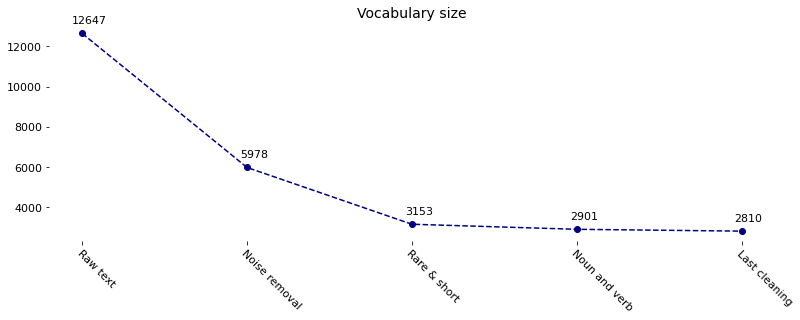

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [ ]:
plt.figure(figsize=(13,4))
plt.clf()
plt.plot(process,count,'o--',color='navy')

# zip joins x and y coordinates in pairs
for x,y in vocab_size:

    label = "{:.0f}".format(y)

    plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(7,10), # distance from text to points (x,y)
                 ha='center',
                fontsize=11)

plt.title('Vocabulary size',fontsize=14,color='black')
plt.xticks(fontsize=11,rotation=-45, ha="left",rotation_mode="anchor",color='black')
plt.yticks(fontsize=11)
plt.box(False)
plt.show()

In [ ]:
song.to_pickle('TopicModeling.pkl')

**Topic Modelling**

In [ ]:
from nltk import word_tokenize
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models

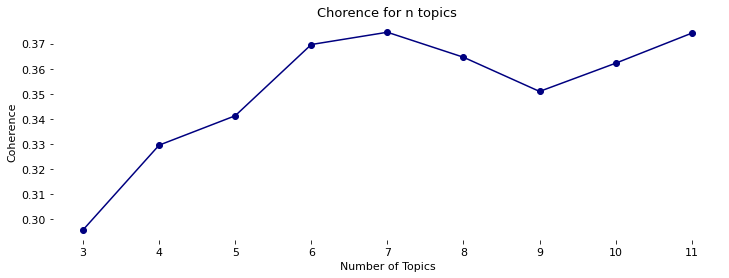

In [ ]:
#Prepping model inputs
corpus = song['clean2'].values.tolist()
tok_corp= [word_tokenize(sent) for sent in corpus]
lexi = corpora.Dictionary(tok_corp)
corpus = [lexi.doc2bow(d) for d in tok_corp]


#Choose n parameter based on coherence measure
coherence_vals = []
for k in range(3,12):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k,id2word = lexi, eval_every=1,random_state=10)

    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=tok_corp, dictionary=lexi, coherence='c_v')   

    coherence_vals.append((k,cm.get_coherence()))

n_topics = [x[0] for x in coherence_vals]
coherence = [x[1] for x in coherence_vals]

plt.plot(n_topics,coherence,color='navy')
plt.scatter(n_topics,coherence,color='navy')
plt.xlabel('Number of Topics',fontsize=11,color='black')
plt.ylabel('Coherence', fontsize=11,color='black')
plt.xticks(n_topics,fontsize=11,color='black')
plt.yticks(fontsize=11,color='black')
plt.title('Chorence for n topics',fontsize=13,color='black')
plt.box(False)
plt.show()

In [ ]:
n_sub_topics= 7
#+coherence.index(max(coherence))
lda = LdaModel(corpus=corpus, id2word=lexi,  num_topics=n_sub_topics, 
            update_every=1, alpha='auto', random_state=10,eval_every=1)
#, iterations=20passes=20,chunksize=100,

In [ ]:
topic_data =  pyLDAvis.gensim_models.prepare(lda, corpus, lexi, mds = 'pcoa')
all_topics = {}
num_terms = 6 # Adjust number of words to represent each topic
lambd = 0.8# Adjust this accordingly based on tuning above
for i in range(1,n_sub_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    topic_df = pd.DataFrame(all_topics).T

In [ ]:
topic_df

0      1      2       3      4      5
Topic 1  nigga   love  bitch     hit    try   play
Topic 2   love   fuck   life   happy   clap     ti
Topic 3  nigga   fuck   shit   bitch   life   play
Topic 4   baby   life   good    love   lord  nigga
Topic 5   work  chick   shit  badder   good  world
Topic 6  dance   baby   love  prayer   babe  nigga
Topic 7   love  bitch  party   shake  nigga  money

### Topic Modeling pr genre

### WorldClouds

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud

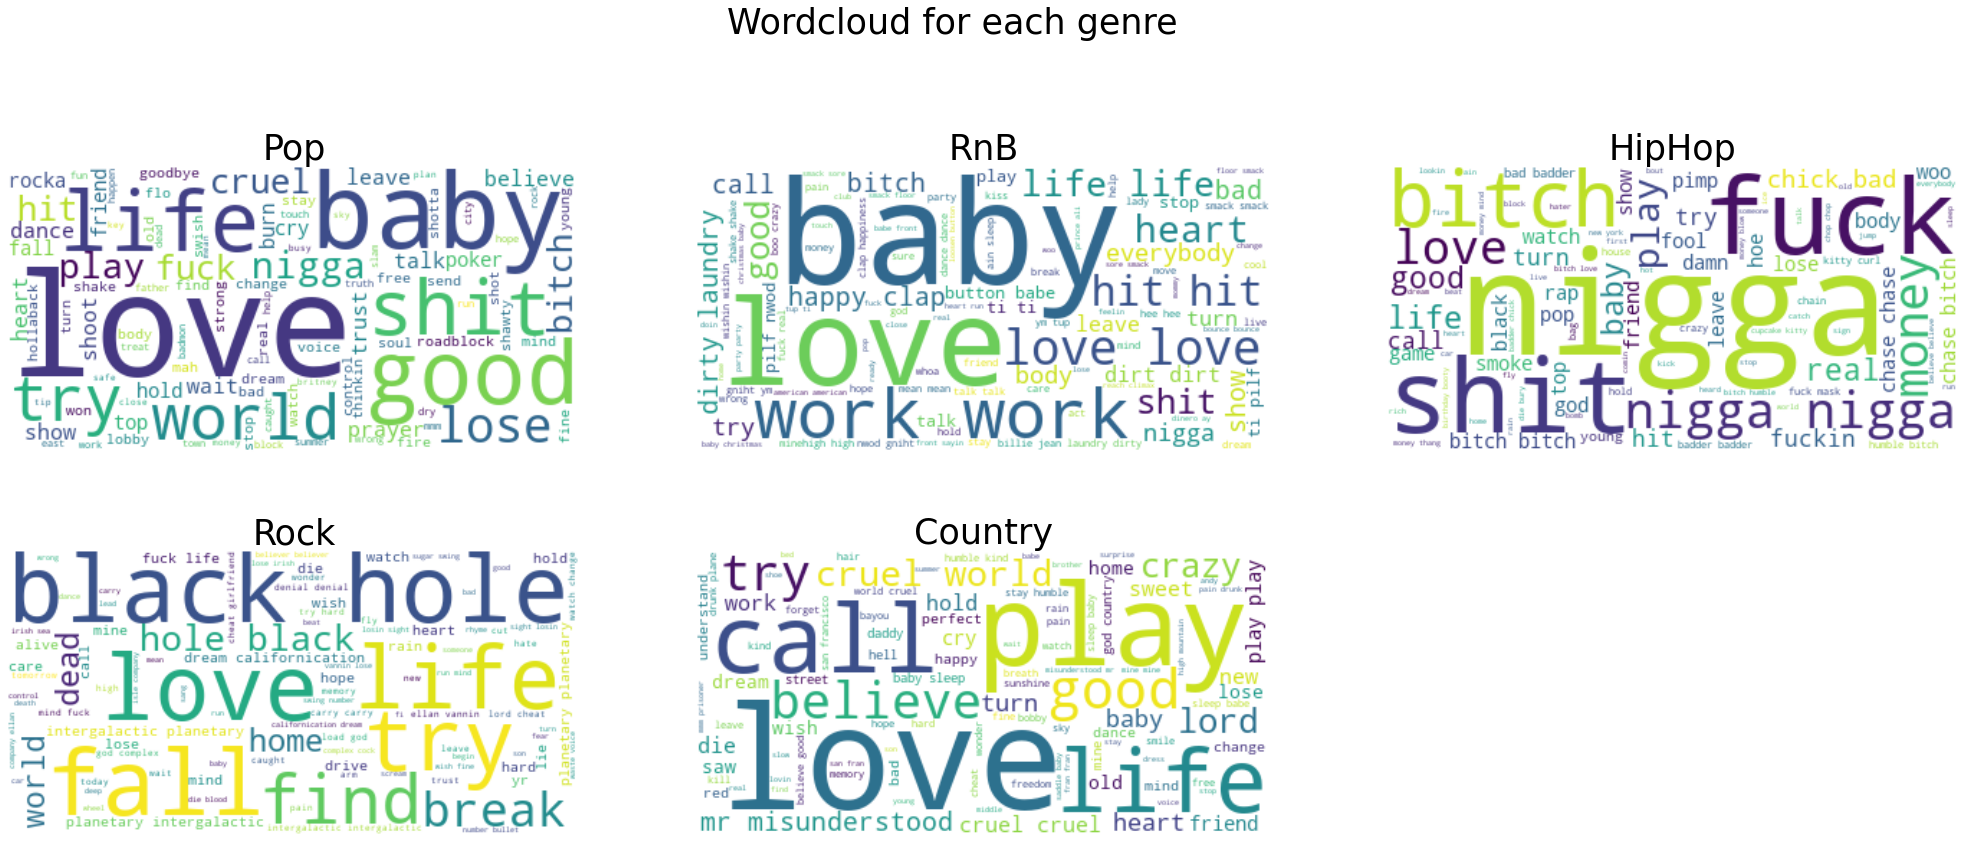

In [ ]:
from PIL import Image

plt.rcParams['figure.figsize'] = [35, 20]
fig = plt.figure()

ax1 = fig.add_subplot(3,3,1)
text = ' '.join(song[song.genre=='Pop']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white", collocations=False,  contour_width=3, contour_color='black').generate(text)
ax1.imshow(fig_wordcloud, interpolation="bilinear")  
ax1.axis('off')
#ax1.title("Pop", fontsize=20)
ax1.set_title('Pop', fontdict={'fontsize': 35, 'fontweight': 'medium'})

ax2 = fig.add_subplot(3,3,2)
text = ' '.join(song[song.genre=='RnB']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax2.imshow(fig_wordcloud, interpolation="bilinear")  
ax2.axis('off')
#ax1.title("Pop", fontsize=20)
ax2.set_title('RnB', fontdict={'fontsize': 35, 'fontweight': 'medium'})

ax3 = fig.add_subplot(3,3,3)
text = ' '.join(song[song.genre=='HipHop']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax3.imshow(fig_wordcloud, interpolation="bilinear")  
ax3.axis('off')
#ax1.title("Pop", fontsize=20)
ax3.set_title('HipHop', fontdict={'fontsize': 35, 'fontweight': 'medium'})

ax4 = fig.add_subplot(3,3,4)
text = ' '.join(song[song.genre=='Rock']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax4.imshow(fig_wordcloud, interpolation="bilinear")  
ax4.axis('off')
#ax1.title("Pop", fontsize=20)
ax4.set_title('Rock', fontdict={'fontsize': 35, 'fontweight': 'medium'})

ax5 = fig.add_subplot(3,3,5)
text = ' '.join(song[song.genre=='Country']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax5.imshow(fig_wordcloud, interpolation="bilinear")  
ax5.axis('off')
#ax1.title("Pop", fontsize=20)
ax5.set_title('Country', fontdict={'fontsize': 35, 'fontweight': 'medium'})

fig.suptitle('Wordcloud for each genre', fontsize=35)
plt.show()

It is clear to see that Pop and RnB has the same words where HipHop uses different words. 

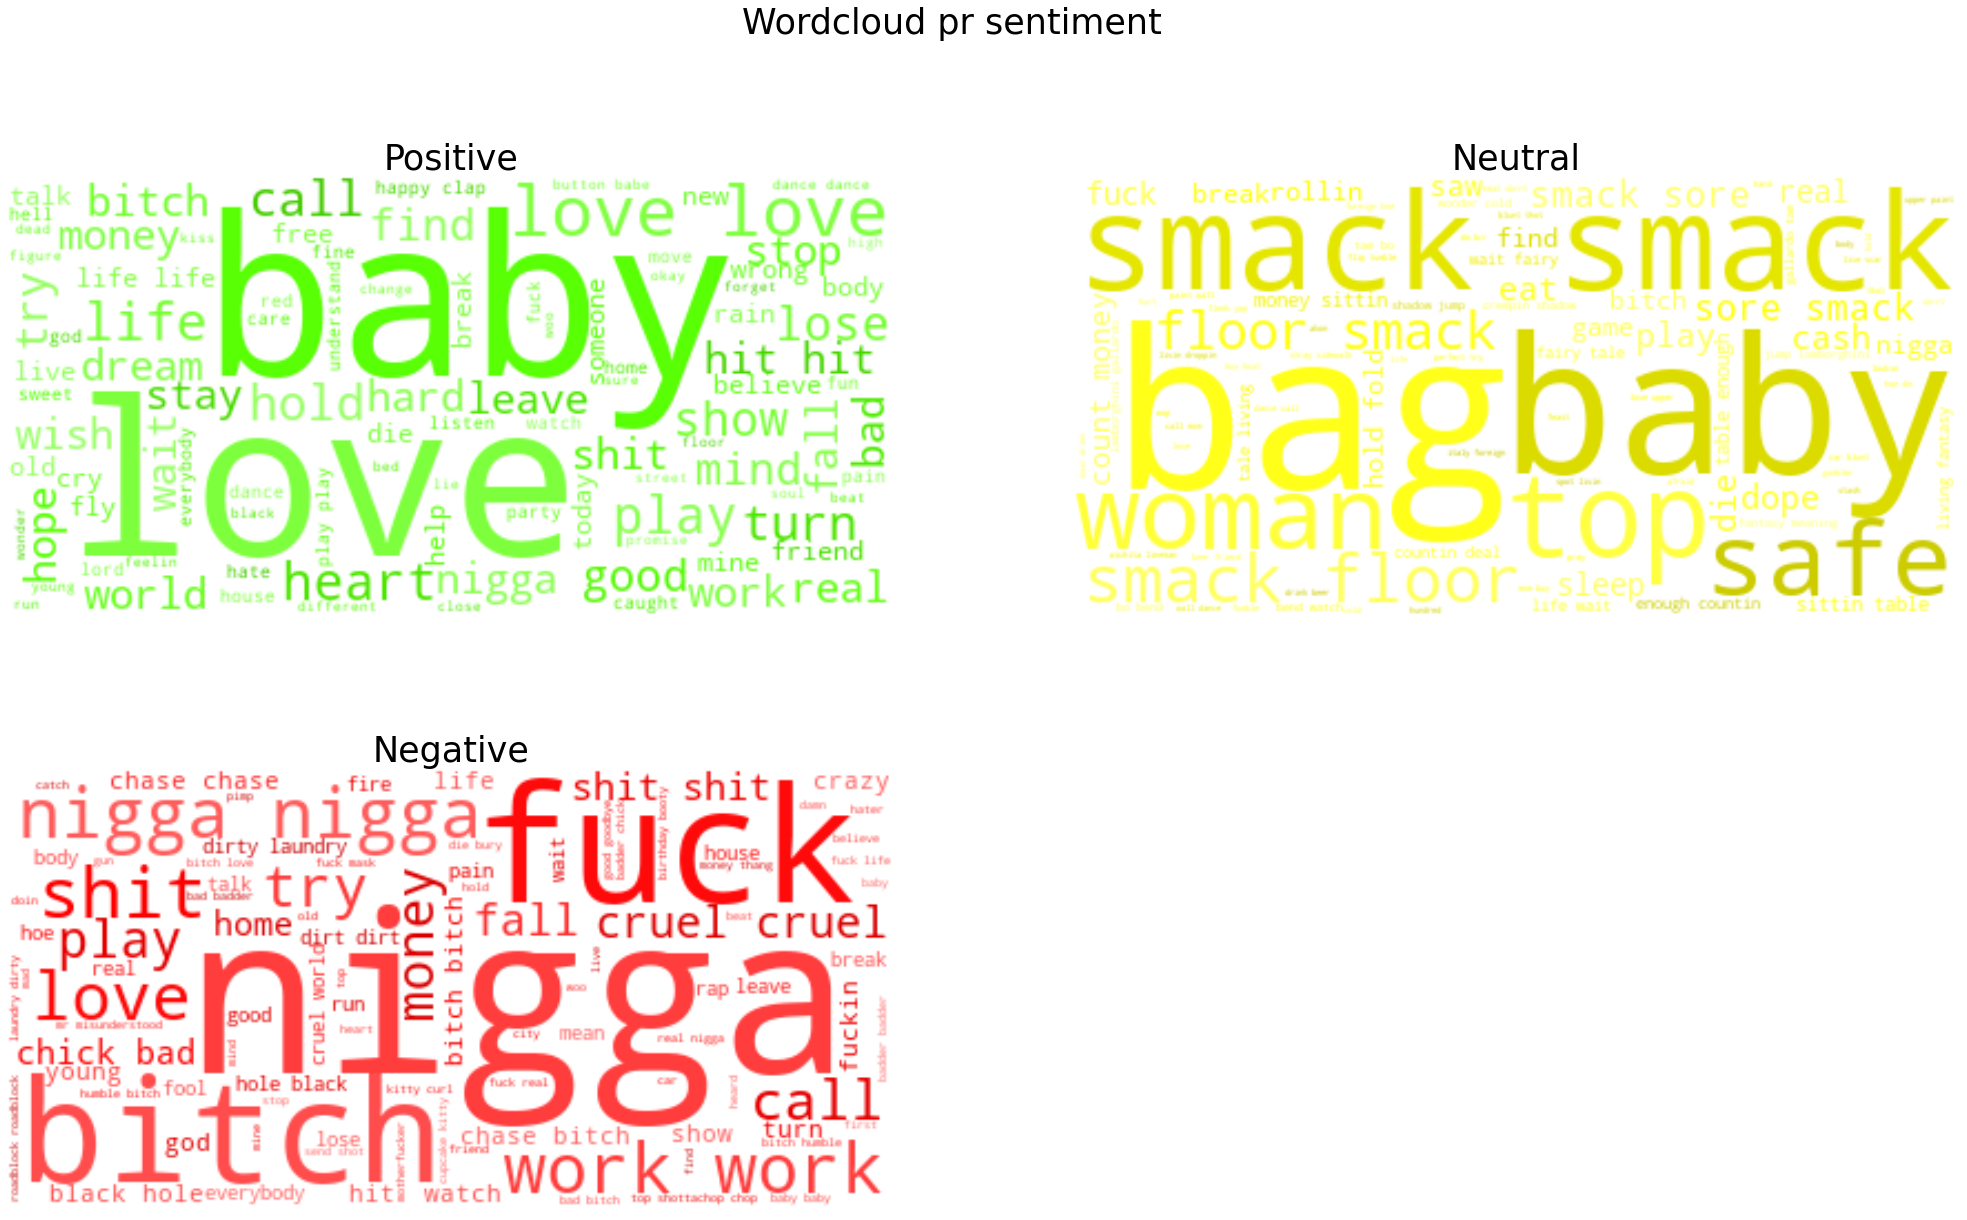

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [ ]:
def green_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(100, 100%%, %d%%)" % random.randint(40, 70)

def yellow_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(60, 100%%, %d%%)" % random.randint(40, 70)

def red_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(40, 70)




plt.rcParams['figure.figsize'] = [35, 20]
fig = plt.figure()

ax1 = fig.add_subplot(2,2,1)
text = ' '.join(song[song.Sentiment=='Positive']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax1.imshow(fig_wordcloud.recolor(color_func=green_func, random_state=3),
           interpolation="bilinear") 
ax1.axis('off')
#ax1.title("Pop", fontsize=20)
ax1.set_title('Positive', fontdict={'fontsize': 35, 'fontweight': 'medium'})

ax2 = fig.add_subplot(2,2,2)
text = ' '.join(song[song.Sentiment=='Neutral']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax2.imshow(fig_wordcloud.recolor(color_func=yellow_func, random_state=3),
           interpolation="bilinear")  
ax2.axis('off')
#ax1.title("Pop", fontsize=20)
ax2.set_title('Neutral', fontdict={'fontsize': 35, 'fontweight': 'medium'})

ax3 = fig.add_subplot(2,2,3)
text = ' '.join(song[song.Sentiment=='Negative']['clean2'].astype(str).tolist())
    
fig_wordcloud = wordcloud.WordCloud(stopwords = STOPWORDS,max_font_size=100, max_words=100, background_color="white").generate(text)
ax3.imshow(fig_wordcloud.recolor(color_func=red_func, random_state=3),
           interpolation="bilinear")  
ax3.axis('off')
#ax1.title("Pop", fontsize=20)
ax3.set_title('Negative', fontdict={'fontsize': 35, 'fontweight': 'medium'})

fig.suptitle('Wordcloud pr sentiment', fontsize=35)
plt.show()

**Text analysis outcomes**



<a id='part5'></a>
## Part 5: Discussion

<a id='part6'></a>
## Part 6: Contributions


| Name | Study ID | Contribution |
| --- | --- |--- |
| Cecilie Kosack | s184304| Network Analysis, Basic Stats and project video |
| Amanda Sommer | s184303| Sentiment Analysis, Topic Modelling and homepage |
| Julius Rasmussen | s184288|  Network Analysis, Basic Statis and homepage |

## Functions

## References